In [1]:
# import the libraries
import torch 
from torchvision import transforms , models 
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# Select how to process
process = ("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Using vgg19 to extract features and apply styling on the content images, about 550M will be downloaded for the first time
model = models.vgg19(pretrained=True).features
for param in model.parameters():
    param.requires_grad = False
model.to(process)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
# setting which layers to be used for content extraction and stylings
def model_activation_apply(input,model):
    layers = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x 
    
    return features

In [5]:
# define how to transform
transform = transforms.Compose([transforms.Resize(400),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [6]:
# Load the content and style images and apply transform
content = Image.open("/content/drive/My Drive/Neural_Style/content.jpg").convert("RGB")
content = transform(content).to(process)
print("Content shape => ", content.shape)

style = Image.open("/content/drive/My Drive/Neural_Style/style.jpeg").convert("RGB")
style = transform(style).to(process)
print("Style shape => ", style.shape)

Content shape =>  torch.Size([3, 400, 711])
Style shape =>  torch.Size([3, 400, 614])


In [7]:
def img_convert(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    return np.clip(x, 0, 1)

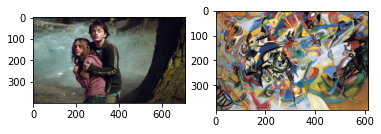

In [8]:
# just plotting the samples
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(img_convert(content),label = "Content")
ax2.imshow(img_convert(style),label = "Style")
plt.show()

In [9]:
def gram_matrix(imgfeature):
    _,d,h,w = imgfeature.size()
    imgfeature = imgfeature.view(d,h*w)
    gram_mat = torch.mm(imgfeature,imgfeature.t())
    
    return gram_mat

In [10]:
target = content.clone().requires_grad_(True).to(process)

In [11]:
# vary these, hit and trial to change results
style_features = model_activation_apply(style,model)
content_features = model_activation_apply(content,model)

style_wt_meas = {"conv1_1" : 1.0, 
                 "conv2_1" : 0.8,
                 "conv3_1" : 0.4,
                 "conv4_1" : 0.2,
                 "conv5_1" : 0.1}

In [12]:
style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

In [13]:
content_wt, style_wt, prt, epochs = 100, 1e8, 500, 6000
optimizer = torch.optim.Adam([target],lr=0.007)

  0%|          | 8/6000 [00:00<03:17, 30.38it/s]

epoch  10   

  0%|          | 16/6000 [00:00<05:50, 17.06it/s]

tensor(2.2034e+19, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 19/6000 [00:00<05:51, 17.01it/s]

epoch  20   

  0%|          | 26/6000 [00:01<05:49, 17.08it/s]

tensor(1.0245e+19, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 29/6000 [00:01<05:50, 17.03it/s]

epoch  30   

  1%|          | 36/6000 [00:01<05:48, 17.10it/s]

tensor(7.7526e+18, device='cuda:0', grad_fn=<AddBackward0>)


  1%|          | 39/6000 [00:02<05:49, 17.04it/s]

epoch  40   

  1%|          | 46/6000 [00:02<05:48, 17.09it/s]

tensor(6.5081e+18, device='cuda:0', grad_fn=<AddBackward0>)


  1%|          | 49/6000 [00:02<05:49, 17.04it/s]

epoch  50   

  1%|          | 56/6000 [00:03<06:34, 15.07it/s]

tensor(5.7530e+18, device='cuda:0', grad_fn=<AddBackward0>)


  1%|          | 59/6000 [00:03<06:21, 15.58it/s]

epoch  60   

  1%|          | 66/6000 [00:03<06:03, 16.34it/s]

tensor(5.2241e+18, device='cuda:0', grad_fn=<AddBackward0>)


  1%|          | 69/6000 [00:03<05:59, 16.51it/s]

epoch  70   

  1%|▏         | 76/6000 [00:04<05:51, 16.83it/s]

tensor(4.8142e+18, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏         | 79/6000 [00:04<05:51, 16.85it/s]

epoch  80   

  1%|▏         | 86/6000 [00:04<05:47, 17.01it/s]

tensor(4.4813e+18, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏         | 89/6000 [00:05<05:48, 16.98it/s]

epoch  90   

  2%|▏         | 96/6000 [00:05<05:45, 17.07it/s]

tensor(4.2006e+18, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 99/6000 [00:05<05:46, 17.02it/s]

epoch  100   

  2%|▏         | 106/6000 [00:06<06:31, 15.06it/s]

tensor(3.9578e+18, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 109/6000 [00:06<06:18, 15.57it/s]

epoch  110   

  2%|▏         | 116/6000 [00:06<06:00, 16.34it/s]

tensor(3.7436e+18, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 119/6000 [00:06<05:56, 16.51it/s]

epoch  120   

  2%|▏         | 126/6000 [00:07<05:49, 16.83it/s]

tensor(3.5518e+18, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 129/6000 [00:07<05:48, 16.85it/s]

epoch  130   

  2%|▏         | 136/6000 [00:07<05:44, 17.01it/s]

tensor(3.3780e+18, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 139/6000 [00:08<05:45, 16.97it/s]

epoch  140   

  2%|▏         | 146/6000 [00:08<05:43, 17.06it/s]

tensor(3.2193e+18, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 149/6000 [00:08<05:43, 17.02it/s]

epoch  150   

  3%|▎         | 156/6000 [00:09<06:28, 15.05it/s]

tensor(3.0734e+18, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 159/6000 [00:09<06:15, 15.57it/s]

epoch  160   

  3%|▎         | 166/6000 [00:09<05:57, 16.34it/s]

tensor(2.9388e+18, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 169/6000 [00:09<05:53, 16.51it/s]

epoch  170   

  3%|▎         | 176/6000 [00:10<05:46, 16.83it/s]

tensor(2.8143e+18, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 179/6000 [00:10<05:45, 16.85it/s]

epoch  180   

  3%|▎         | 186/6000 [00:10<05:41, 17.00it/s]

tensor(2.6990e+18, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 189/6000 [00:10<05:42, 16.97it/s]

epoch  190   

  3%|▎         | 196/6000 [00:11<05:40, 17.06it/s]

tensor(2.5920e+18, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 199/6000 [00:11<05:40, 17.02it/s]

epoch  200   

  3%|▎         | 206/6000 [00:11<05:39, 17.09it/s]

tensor(2.4925e+18, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 209/6000 [00:12<05:39, 17.04it/s]

epoch  210   

  4%|▎         | 216/6000 [00:12<05:38, 17.09it/s]

tensor(2.3999e+18, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▎         | 219/6000 [00:12<05:39, 17.04it/s]

epoch  220   

  4%|▍         | 226/6000 [00:13<05:37, 17.10it/s]

tensor(2.3137e+18, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 229/6000 [00:13<05:38, 17.04it/s]

epoch  230   

  4%|▍         | 236/6000 [00:13<05:37, 17.10it/s]

tensor(2.2333e+18, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 239/6000 [00:13<05:38, 17.04it/s]

epoch  240   

  4%|▍         | 246/6000 [00:14<05:36, 17.10it/s]

tensor(2.1583e+18, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 249/6000 [00:14<05:37, 17.04it/s]

epoch  250   

  4%|▍         | 256/6000 [00:14<05:35, 17.10it/s]

tensor(2.0883e+18, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 259/6000 [00:15<05:36, 17.04it/s]

epoch  260   

  4%|▍         | 266/6000 [00:15<05:35, 17.10it/s]

tensor(2.0229e+18, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 269/6000 [00:15<05:36, 17.04it/s]

epoch  270   

  5%|▍         | 276/6000 [00:16<06:19, 15.07it/s]

tensor(1.9617e+18, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▍         | 279/6000 [00:16<06:07, 15.58it/s]

epoch  280   

  5%|▍         | 286/6000 [00:16<05:49, 16.34it/s]

tensor(1.9045e+18, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▍         | 289/6000 [00:16<05:45, 16.51it/s]

epoch  290   

  5%|▍         | 296/6000 [00:17<05:39, 16.82it/s]

tensor(1.8511e+18, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▍         | 299/6000 [00:17<05:38, 16.85it/s]

epoch  300   

  5%|▌         | 306/6000 [00:17<05:34, 17.00it/s]

tensor(1.8011e+18, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▌         | 309/6000 [00:18<05:35, 16.98it/s]

epoch  310   

  5%|▌         | 316/6000 [00:18<06:17, 15.04it/s]

tensor(1.7542e+18, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▌         | 319/6000 [00:18<06:05, 15.56it/s]

epoch  320   

  5%|▌         | 326/6000 [00:19<05:47, 16.33it/s]

tensor(1.7104e+18, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▌         | 329/6000 [00:19<05:43, 16.50it/s]

epoch  330   

  6%|▌         | 336/6000 [00:19<05:36, 16.83it/s]

tensor(1.6693e+18, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 339/6000 [00:19<05:35, 16.85it/s]

epoch  340   

  6%|▌         | 346/6000 [00:20<05:32, 17.00it/s]

tensor(1.6307e+18, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 349/6000 [00:20<05:32, 16.97it/s]

epoch  350   

  6%|▌         | 356/6000 [00:20<06:15, 15.02it/s]

tensor(1.5944e+18, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 359/6000 [00:21<06:03, 15.54it/s]

epoch  360   

  6%|▌         | 366/6000 [00:21<05:45, 16.32it/s]

tensor(1.5604e+18, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 369/6000 [00:21<05:41, 16.49it/s]

epoch  370   

  6%|▋         | 376/6000 [00:22<05:34, 16.82it/s]

tensor(1.5284e+18, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▋         | 379/6000 [00:22<05:33, 16.85it/s]

epoch  380   

  6%|▋         | 386/6000 [00:22<05:30, 17.00it/s]

tensor(1.4984e+18, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▋         | 389/6000 [00:22<05:30, 16.98it/s]

epoch  390   

  7%|▋         | 396/6000 [00:23<05:28, 17.06it/s]

tensor(1.4701e+18, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 399/6000 [00:23<05:29, 17.02it/s]

epoch  400   

  7%|▋         | 406/6000 [00:23<06:11, 15.06it/s]

tensor(1.4434e+18, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 409/6000 [00:24<05:59, 15.57it/s]

epoch  410   

  7%|▋         | 416/6000 [00:24<05:41, 16.34it/s]

tensor(1.4183e+18, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 419/6000 [00:24<05:38, 16.51it/s]

epoch  420   

  7%|▋         | 426/6000 [00:25<05:31, 16.83it/s]

tensor(1.3947e+18, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 429/6000 [00:25<05:30, 16.85it/s]

epoch  430   

  7%|▋         | 436/6000 [00:25<05:27, 17.00it/s]

tensor(1.3724e+18, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 439/6000 [00:25<05:27, 16.97it/s]

epoch  440   

  7%|▋         | 446/6000 [00:26<05:25, 17.05it/s]

tensor(1.3513e+18, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 449/6000 [00:26<05:26, 17.01it/s]

epoch  450   

  8%|▊         | 456/6000 [00:26<06:08, 15.05it/s]

tensor(1.3315e+18, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 459/6000 [00:26<05:55, 15.57it/s]

epoch  460   

  8%|▊         | 466/6000 [00:27<05:38, 16.33it/s]

tensor(1.3127e+18, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 469/6000 [00:27<05:35, 16.51it/s]

epoch  470   

  8%|▊         | 476/6000 [00:28<05:28, 16.83it/s]

tensor(1.2949e+18, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 479/6000 [00:28<05:27, 16.85it/s]

epoch  480   

  8%|▊         | 486/6000 [00:28<05:24, 17.00it/s]

tensor(1.2780e+18, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 489/6000 [00:28<05:24, 16.98it/s]

epoch  490   

  8%|▊         | 496/6000 [00:29<05:23, 17.04it/s]

tensor(1.2620e+18, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 499/6000 [00:29<05:23, 17.00it/s]

epoch  500   tensor(1.2468e+18, device='cuda:0', grad_fn=<AddBackward0>)


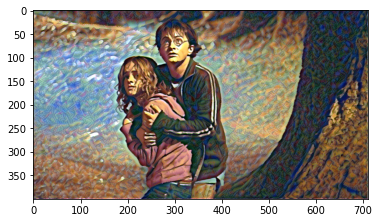

  8%|▊         | 507/6000 [00:30<07:53, 11.60it/s]

epoch  510   

  9%|▊         | 516/6000 [00:30<07:01, 13.02it/s]

tensor(1.2324e+18, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▊         | 519/6000 [00:30<06:31, 13.98it/s]

epoch  520   

  9%|▉         | 526/6000 [00:31<05:54, 15.44it/s]

tensor(1.2187e+18, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▉         | 529/6000 [00:31<05:45, 15.85it/s]

epoch  530   

  9%|▉         | 536/6000 [00:31<05:31, 16.49it/s]

tensor(1.2056e+18, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▉         | 539/6000 [00:32<05:28, 16.62it/s]

epoch  540   

  9%|▉         | 546/6000 [00:32<05:23, 16.88it/s]

tensor(1.1933e+18, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▉         | 549/6000 [00:32<05:22, 16.88it/s]

epoch  550   

  9%|▉         | 556/6000 [00:33<05:19, 17.02it/s]

tensor(1.1815e+18, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▉         | 559/6000 [00:33<05:20, 16.98it/s]

epoch  560   

  9%|▉         | 566/6000 [00:33<05:18, 17.07it/s]

tensor(1.1702e+18, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▉         | 569/6000 [00:33<05:19, 17.02it/s]

epoch  570   

 10%|▉         | 576/6000 [00:34<06:00, 15.05it/s]

tensor(1.1595e+18, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▉         | 579/6000 [00:34<05:48, 15.56it/s]

epoch  580   

 10%|▉         | 586/6000 [00:34<05:31, 16.33it/s]

tensor(1.1493e+18, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▉         | 589/6000 [00:35<05:27, 16.51it/s]

epoch  590   

 10%|▉         | 596/6000 [00:35<05:21, 16.83it/s]

tensor(1.1396e+18, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▉         | 599/6000 [00:35<05:20, 16.85it/s]

epoch  600   

 10%|█         | 606/6000 [00:36<05:17, 17.01it/s]

tensor(1.1303e+18, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 609/6000 [00:36<05:17, 16.98it/s]

epoch  610   

 10%|█         | 616/6000 [00:36<05:15, 17.06it/s]

tensor(1.1214e+18, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 619/6000 [00:36<05:16, 17.02it/s]

epoch  620   

 10%|█         | 626/6000 [00:37<05:14, 17.09it/s]

tensor(1.1128e+18, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 629/6000 [00:37<05:15, 17.03it/s]

epoch  630   

 11%|█         | 636/6000 [00:37<05:13, 17.09it/s]

tensor(1.1047e+18, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█         | 639/6000 [00:38<05:14, 17.04it/s]

epoch  640   

 11%|█         | 646/6000 [00:38<05:13, 17.09it/s]

tensor(1.0968e+18, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█         | 649/6000 [00:38<05:14, 17.04it/s]

epoch  650   

 11%|█         | 656/6000 [00:39<05:12, 17.10it/s]

tensor(1.0893e+18, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█         | 659/6000 [00:39<05:13, 17.04it/s]

epoch  660   

 11%|█         | 666/6000 [00:39<05:11, 17.10it/s]

tensor(1.0820e+18, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█         | 669/6000 [00:39<05:12, 17.04it/s]

epoch  670   

 11%|█▏        | 676/6000 [00:40<05:11, 17.10it/s]

tensor(1.0751e+18, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▏        | 679/6000 [00:40<05:12, 17.04it/s]

epoch  680   

 11%|█▏        | 686/6000 [00:40<05:10, 17.10it/s]

tensor(1.0684e+18, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▏        | 689/6000 [00:41<05:11, 17.04it/s]

epoch  690   

 12%|█▏        | 696/6000 [00:41<05:52, 15.06it/s]

tensor(1.0620e+18, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 699/6000 [00:41<05:40, 15.58it/s]

epoch  700   

 12%|█▏        | 706/6000 [00:42<05:23, 16.34it/s]

tensor(1.0558e+18, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 709/6000 [00:42<05:20, 16.51it/s]

epoch  710   

 12%|█▏        | 716/6000 [00:42<05:13, 16.83it/s]

tensor(1.0498e+18, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 719/6000 [00:42<05:13, 16.86it/s]

epoch  720   

 12%|█▏        | 726/6000 [00:43<05:10, 17.00it/s]

tensor(1.0440e+18, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 729/6000 [00:43<05:10, 16.97it/s]

epoch  730   

 12%|█▏        | 736/6000 [00:43<05:08, 17.06it/s]

tensor(1.0385e+18, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 739/6000 [00:43<05:09, 17.01it/s]

epoch  740   

 12%|█▏        | 746/6000 [00:44<05:48, 15.06it/s]

tensor(1.0331e+18, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 749/6000 [00:44<05:37, 15.57it/s]

epoch  750   

 13%|█▎        | 756/6000 [00:44<05:20, 16.34it/s]

tensor(1.0279e+18, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 759/6000 [00:45<05:17, 16.51it/s]

epoch  760   

 13%|█▎        | 766/6000 [00:45<05:10, 16.83it/s]

tensor(1.0229e+18, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 769/6000 [00:45<05:10, 16.85it/s]

epoch  770   

 13%|█▎        | 776/6000 [00:46<05:07, 17.01it/s]

tensor(1.0180e+18, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 779/6000 [00:46<05:07, 16.98it/s]

epoch  780   

 13%|█▎        | 786/6000 [00:46<05:05, 17.06it/s]

tensor(1.0133e+18, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 789/6000 [00:46<05:06, 17.02it/s]

epoch  790   

 13%|█▎        | 796/6000 [00:47<05:45, 15.07it/s]

tensor(1.0087e+18, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 799/6000 [00:47<05:33, 15.58it/s]

epoch  800   

 13%|█▎        | 806/6000 [00:47<05:17, 16.34it/s]

tensor(1.0043e+18, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 809/6000 [00:48<05:14, 16.51it/s]

epoch  810   

 14%|█▎        | 816/6000 [00:48<05:08, 16.82it/s]

tensor(9.9997e+17, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▎        | 819/6000 [00:48<05:07, 16.85it/s]

epoch  820   

 14%|█▍        | 826/6000 [00:49<05:04, 17.01it/s]

tensor(9.9580e+17, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 829/6000 [00:49<05:04, 16.98it/s]

epoch  830   

 14%|█▍        | 836/6000 [00:49<05:02, 17.06it/s]

tensor(9.9176e+17, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 839/6000 [00:49<05:03, 17.01it/s]

epoch  840   

 14%|█▍        | 846/6000 [00:50<05:42, 15.07it/s]

tensor(9.8785e+17, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 849/6000 [00:50<05:30, 15.57it/s]

epoch  850   

 14%|█▍        | 856/6000 [00:50<05:14, 16.34it/s]

tensor(9.8404e+17, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 859/6000 [00:51<05:11, 16.51it/s]

epoch  860   

 14%|█▍        | 866/6000 [00:51<05:05, 16.82it/s]

tensor(9.8034e+17, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 869/6000 [00:51<05:04, 16.85it/s]

epoch  870   

 15%|█▍        | 876/6000 [00:52<05:01, 17.00it/s]

tensor(9.7675e+17, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▍        | 879/6000 [00:52<05:01, 16.97it/s]

epoch  880   

 15%|█▍        | 886/6000 [00:52<04:59, 17.07it/s]

tensor(9.7326e+17, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▍        | 889/6000 [00:52<05:00, 17.02it/s]

epoch  890   

 15%|█▍        | 896/6000 [00:53<05:38, 15.06it/s]

tensor(9.6985e+17, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▍        | 899/6000 [00:53<05:27, 15.57it/s]

epoch  900   

 15%|█▌        | 906/6000 [00:53<05:11, 16.34it/s]

tensor(9.6654e+17, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 909/6000 [00:54<05:08, 16.51it/s]

epoch  910   

 15%|█▌        | 916/6000 [00:54<05:02, 16.83it/s]

tensor(9.6333e+17, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 919/6000 [00:54<05:01, 16.85it/s]

epoch  920   

 15%|█▌        | 926/6000 [00:55<04:58, 17.01it/s]

tensor(9.6020e+17, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 929/6000 [00:55<04:58, 16.98it/s]

epoch  930   

 16%|█▌        | 936/6000 [00:55<04:56, 17.06it/s]

tensor(9.5716e+17, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 939/6000 [00:55<04:57, 17.02it/s]

epoch  940   

 16%|█▌        | 946/6000 [00:56<05:35, 15.06it/s]

tensor(9.5419e+17, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 949/6000 [00:56<05:24, 15.57it/s]

epoch  950   

 16%|█▌        | 956/6000 [00:56<05:08, 16.34it/s]

tensor(9.5130e+17, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 959/6000 [00:57<05:05, 16.51it/s]

epoch  960   

 16%|█▌        | 966/6000 [00:57<04:59, 16.83it/s]

tensor(9.4848e+17, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 969/6000 [00:57<04:58, 16.86it/s]

epoch  970   

 16%|█▋        | 976/6000 [00:58<04:55, 17.01it/s]

tensor(9.4572e+17, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▋        | 979/6000 [00:58<04:55, 16.98it/s]

epoch  980   

 16%|█▋        | 986/6000 [00:58<05:33, 15.04it/s]

tensor(9.4304e+17, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▋        | 989/6000 [00:58<05:22, 15.56it/s]

epoch  990   

 17%|█▋        | 996/6000 [00:59<05:06, 16.33it/s]

tensor(9.4041e+17, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 999/6000 [00:59<05:03, 16.50it/s]

epoch  1000   tensor(9.3785e+17, device='cuda:0', grad_fn=<AddBackward0>)


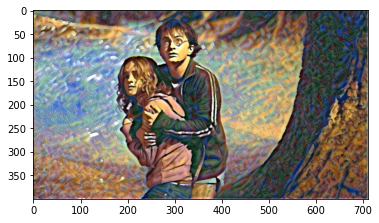

 17%|█▋        | 1007/6000 [01:00<07:13, 11.52it/s]

epoch  1010   

 17%|█▋        | 1016/6000 [01:00<06:24, 12.97it/s]

tensor(9.3535e+17, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 1019/6000 [01:00<05:57, 13.94it/s]

epoch  1020   

 17%|█▋        | 1026/6000 [01:01<05:22, 15.42it/s]

tensor(9.3291e+17, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 1029/6000 [01:01<05:13, 15.84it/s]

epoch  1030   

 17%|█▋        | 1036/6000 [01:01<05:01, 16.48it/s]

tensor(9.3052e+17, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 1039/6000 [01:02<04:58, 16.60it/s]

epoch  1040   

 17%|█▋        | 1046/6000 [01:02<04:53, 16.88it/s]

tensor(9.2819e+17, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 1049/6000 [01:02<04:53, 16.89it/s]

epoch  1050   

 18%|█▊        | 1056/6000 [01:03<04:50, 17.02it/s]

tensor(9.2591e+17, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 1059/6000 [01:03<04:50, 16.99it/s]

epoch  1060   

 18%|█▊        | 1066/6000 [01:03<05:28, 15.04it/s]

tensor(9.2368e+17, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 1069/6000 [01:03<05:17, 15.55it/s]

epoch  1070   

 18%|█▊        | 1076/6000 [01:04<05:01, 16.33it/s]

tensor(9.2150e+17, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 1079/6000 [01:04<04:58, 16.50it/s]

epoch  1080   

 18%|█▊        | 1086/6000 [01:04<04:52, 16.83it/s]

tensor(9.1937e+17, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 1089/6000 [01:05<04:51, 16.85it/s]

epoch  1090   

 18%|█▊        | 1096/6000 [01:05<04:48, 17.00it/s]

tensor(9.1729e+17, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 1099/6000 [01:05<04:48, 16.97it/s]

epoch  1100   

 18%|█▊        | 1106/6000 [01:06<05:25, 15.05it/s]

tensor(9.1525e+17, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 1109/6000 [01:06<05:14, 15.56it/s]

epoch  1110   

 19%|█▊        | 1116/6000 [01:06<04:59, 16.33it/s]

tensor(9.1326e+17, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▊        | 1119/6000 [01:06<04:55, 16.50it/s]

epoch  1120   

 19%|█▉        | 1126/6000 [01:07<04:49, 16.83it/s]

tensor(9.1130e+17, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▉        | 1129/6000 [01:07<04:48, 16.86it/s]

epoch  1130   

 19%|█▉        | 1136/6000 [01:07<04:46, 17.01it/s]

tensor(9.0939e+17, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▉        | 1139/6000 [01:08<04:46, 16.97it/s]

epoch  1140   

 19%|█▉        | 1146/6000 [01:08<05:22, 15.05it/s]

tensor(9.0751e+17, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▉        | 1149/6000 [01:08<05:11, 15.56it/s]

epoch  1150   

 19%|█▉        | 1156/6000 [01:09<04:56, 16.34it/s]

tensor(9.0566e+17, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▉        | 1159/6000 [01:09<04:53, 16.51it/s]

epoch  1160   

 19%|█▉        | 1166/6000 [01:09<04:47, 16.83it/s]

tensor(9.0386e+17, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▉        | 1169/6000 [01:09<04:46, 16.85it/s]

epoch  1170   

 20%|█▉        | 1176/6000 [01:10<04:43, 17.00it/s]

tensor(9.0209e+17, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█▉        | 1179/6000 [01:10<04:43, 16.98it/s]

epoch  1180   

 20%|█▉        | 1186/6000 [01:10<05:20, 15.01it/s]

tensor(9.0035e+17, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█▉        | 1189/6000 [01:11<05:09, 15.54it/s]

epoch  1190   

 20%|█▉        | 1196/6000 [01:11<04:54, 16.32it/s]

tensor(8.9865e+17, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█▉        | 1199/6000 [01:11<04:51, 16.49it/s]

epoch  1200   

 20%|██        | 1206/6000 [01:12<04:44, 16.83it/s]

tensor(8.9698e+17, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 1209/6000 [01:12<04:44, 16.85it/s]

epoch  1210   

 20%|██        | 1216/6000 [01:12<04:41, 17.00it/s]

tensor(8.9534e+17, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 1219/6000 [01:12<04:41, 16.98it/s]

epoch  1220   

 20%|██        | 1226/6000 [01:13<04:39, 17.07it/s]

tensor(8.9373e+17, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 1229/6000 [01:13<04:40, 17.02it/s]

epoch  1230   

 21%|██        | 1236/6000 [01:13<05:16, 15.06it/s]

tensor(8.9215e+17, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██        | 1239/6000 [01:13<05:05, 15.57it/s]

epoch  1240   

 21%|██        | 1246/6000 [01:14<04:50, 16.34it/s]

tensor(8.9060e+17, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██        | 1249/6000 [01:14<04:47, 16.51it/s]

epoch  1250   

 21%|██        | 1256/6000 [01:14<04:41, 16.83it/s]

tensor(8.8907e+17, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██        | 1259/6000 [01:15<04:41, 16.86it/s]

epoch  1260   

 21%|██        | 1266/6000 [01:15<04:38, 17.01it/s]

tensor(8.8758e+17, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██        | 1269/6000 [01:15<04:38, 16.97it/s]

epoch  1270   

 21%|██▏       | 1276/6000 [01:16<05:14, 15.04it/s]

tensor(8.8612e+17, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▏       | 1279/6000 [01:16<05:03, 15.55it/s]

epoch  1280   

 21%|██▏       | 1286/6000 [01:16<04:48, 16.33it/s]

tensor(8.8467e+17, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▏       | 1289/6000 [01:16<04:45, 16.50it/s]

epoch  1290   

 22%|██▏       | 1296/6000 [01:17<04:39, 16.83it/s]

tensor(8.8326e+17, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 1299/6000 [01:17<04:38, 16.85it/s]

epoch  1300   

 22%|██▏       | 1306/6000 [01:17<04:36, 17.01it/s]

tensor(8.8186e+17, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 1309/6000 [01:18<04:36, 16.98it/s]

epoch  1310   

 22%|██▏       | 1316/6000 [01:18<04:34, 17.06it/s]

tensor(8.8049e+17, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 1319/6000 [01:18<04:35, 17.02it/s]

epoch  1320   

 22%|██▏       | 1326/6000 [01:19<05:10, 15.07it/s]

tensor(8.7914e+17, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 1329/6000 [01:19<04:59, 15.58it/s]

epoch  1330   

 22%|██▏       | 1336/6000 [01:19<04:45, 16.35it/s]

tensor(8.7781e+17, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 1339/6000 [01:19<04:42, 16.51it/s]

epoch  1340   

 22%|██▏       | 1346/6000 [01:20<04:36, 16.83it/s]

tensor(8.7650e+17, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 1349/6000 [01:20<04:35, 16.86it/s]

epoch  1350   

 23%|██▎       | 1356/6000 [01:20<04:33, 17.01it/s]

tensor(8.7521e+17, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 1359/6000 [01:21<04:33, 16.98it/s]

epoch  1360   

 23%|██▎       | 1366/6000 [01:21<04:31, 17.07it/s]

tensor(8.7395e+17, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 1369/6000 [01:21<04:32, 17.02it/s]

epoch  1370   

 23%|██▎       | 1376/6000 [01:22<05:06, 15.07it/s]

tensor(8.7271e+17, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 1379/6000 [01:22<04:56, 15.58it/s]

epoch  1380   

 23%|██▎       | 1386/6000 [01:22<04:42, 16.35it/s]

tensor(8.7148e+17, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 1389/6000 [01:22<04:39, 16.51it/s]

epoch  1390   

 23%|██▎       | 1396/6000 [01:23<04:33, 16.83it/s]

tensor(8.7026e+17, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 1399/6000 [01:23<04:33, 16.85it/s]

epoch  1400   

 23%|██▎       | 1406/6000 [01:23<04:30, 17.00it/s]

tensor(8.6907e+17, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 1409/6000 [01:24<04:30, 16.97it/s]

epoch  1410   

 24%|██▎       | 1416/6000 [01:24<05:04, 15.05it/s]

tensor(8.6790e+17, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▎       | 1419/6000 [01:24<04:54, 15.56it/s]

epoch  1420   

 24%|██▍       | 1426/6000 [01:25<04:39, 16.34it/s]

tensor(8.6675e+17, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 1429/6000 [01:25<04:36, 16.50it/s]

epoch  1430   

 24%|██▍       | 1436/6000 [01:25<04:31, 16.83it/s]

tensor(8.6562e+17, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 1439/6000 [01:25<04:30, 16.85it/s]

epoch  1440   

 24%|██▍       | 1446/6000 [01:26<04:27, 17.00it/s]

tensor(8.6450e+17, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 1449/6000 [01:26<04:28, 16.97it/s]

epoch  1450   

 24%|██▍       | 1456/6000 [01:26<05:01, 15.05it/s]

tensor(8.6340e+17, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 1459/6000 [01:27<04:51, 15.56it/s]

epoch  1460   

 24%|██▍       | 1466/6000 [01:27<04:37, 16.34it/s]

tensor(8.6232e+17, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 1469/6000 [01:27<04:34, 16.51it/s]

epoch  1470   

 25%|██▍       | 1476/6000 [01:28<04:28, 16.83it/s]

tensor(8.6124e+17, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▍       | 1479/6000 [01:28<04:28, 16.85it/s]

epoch  1480   

 25%|██▍       | 1486/6000 [01:28<04:25, 17.00it/s]

tensor(8.6018e+17, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▍       | 1489/6000 [01:28<04:25, 16.97it/s]

epoch  1490   

 25%|██▍       | 1496/6000 [01:29<04:59, 15.05it/s]

tensor(8.5913e+17, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▍       | 1499/6000 [01:29<04:49, 15.56it/s]

epoch  1500   tensor(8.5809e+17, device='cuda:0', grad_fn=<AddBackward0>)


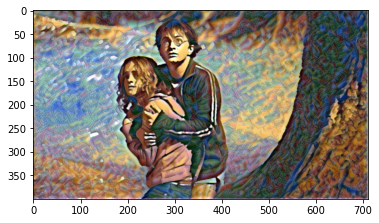

 25%|██▌       | 1507/6000 [01:30<06:38, 11.27it/s]

epoch  1510   

 25%|██▌       | 1516/6000 [01:30<05:50, 12.81it/s]

tensor(8.5707e+17, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▌       | 1519/6000 [01:30<05:24, 13.82it/s]

epoch  1520   

 25%|██▌       | 1526/6000 [01:31<04:51, 15.34it/s]

tensor(8.5607e+17, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▌       | 1529/6000 [01:31<04:43, 15.78it/s]

epoch  1530   

 26%|██▌       | 1536/6000 [01:31<04:31, 16.45it/s]

tensor(8.5507e+17, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 1539/6000 [01:32<04:28, 16.59it/s]

epoch  1540   

 26%|██▌       | 1546/6000 [01:32<04:24, 16.87it/s]

tensor(8.5409e+17, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 1549/6000 [01:32<04:23, 16.88it/s]

epoch  1550   

 26%|██▌       | 1556/6000 [01:33<04:21, 17.01it/s]

tensor(8.5312e+17, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 1559/6000 [01:33<04:21, 16.97it/s]

epoch  1560   

 26%|██▌       | 1566/6000 [01:33<04:54, 15.04it/s]

tensor(8.5216e+17, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 1569/6000 [01:33<04:44, 15.56it/s]

epoch  1570   

 26%|██▋       | 1576/6000 [01:34<04:30, 16.33it/s]

tensor(8.5121e+17, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▋       | 1579/6000 [01:34<04:27, 16.50it/s]

epoch  1580   

 26%|██▋       | 1586/6000 [01:34<04:22, 16.82it/s]

tensor(8.5027e+17, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▋       | 1589/6000 [01:35<04:21, 16.85it/s]

epoch  1590   

 27%|██▋       | 1596/6000 [01:35<04:19, 17.00it/s]

tensor(8.4934e+17, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 1599/6000 [01:35<04:19, 16.97it/s]

epoch  1600   

 27%|██▋       | 1606/6000 [01:36<04:52, 15.04it/s]

tensor(8.4842e+17, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 1609/6000 [01:36<04:42, 15.55it/s]

epoch  1610   

 27%|██▋       | 1616/6000 [01:36<04:28, 16.33it/s]

tensor(8.4750e+17, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 1619/6000 [01:36<04:25, 16.50it/s]

epoch  1620   

 27%|██▋       | 1626/6000 [01:37<04:19, 16.83it/s]

tensor(8.4660e+17, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 1629/6000 [01:37<04:19, 16.85it/s]

epoch  1630   

 27%|██▋       | 1636/6000 [01:37<04:16, 17.01it/s]

tensor(8.4570e+17, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 1639/6000 [01:38<04:16, 16.97it/s]

epoch  1640   

 27%|██▋       | 1646/6000 [01:38<04:15, 17.06it/s]

tensor(8.4480e+17, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 1649/6000 [01:38<04:15, 17.02it/s]

epoch  1650   

 28%|██▊       | 1656/6000 [01:39<04:48, 15.07it/s]

tensor(8.4393e+17, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 1659/6000 [01:39<04:38, 15.58it/s]

epoch  1660   

 28%|██▊       | 1666/6000 [01:39<04:25, 16.34it/s]

tensor(8.4306e+17, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 1669/6000 [01:39<04:22, 16.50it/s]

epoch  1670   

 28%|██▊       | 1676/6000 [01:40<04:16, 16.83it/s]

tensor(8.4220e+17, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 1679/6000 [01:40<04:16, 16.85it/s]

epoch  1680   

 28%|██▊       | 1686/6000 [01:40<04:13, 17.00it/s]

tensor(8.4135e+17, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 1689/6000 [01:41<04:14, 16.97it/s]

epoch  1690   

 28%|██▊       | 1696/6000 [01:41<04:46, 15.04it/s]

tensor(8.4050e+17, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 1699/6000 [01:41<04:36, 15.56it/s]

epoch  1700   

 28%|██▊       | 1706/6000 [01:42<04:22, 16.34it/s]

tensor(8.3966e+17, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 1709/6000 [01:42<04:19, 16.51it/s]

epoch  1710   

 29%|██▊       | 1716/6000 [01:42<04:14, 16.82it/s]

tensor(8.3883e+17, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▊       | 1719/6000 [01:42<04:14, 16.85it/s]

epoch  1720   

 29%|██▉       | 1726/6000 [01:43<04:11, 17.00it/s]

tensor(8.3801e+17, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▉       | 1729/6000 [01:43<04:11, 16.97it/s]

epoch  1730   

 29%|██▉       | 1736/6000 [01:43<04:09, 17.06it/s]

tensor(8.3720e+17, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▉       | 1739/6000 [01:43<04:10, 17.02it/s]

epoch  1740   

 29%|██▉       | 1746/6000 [01:44<04:42, 15.06it/s]

tensor(8.3639e+17, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▉       | 1749/6000 [01:44<04:33, 15.57it/s]

epoch  1750   

 29%|██▉       | 1756/6000 [01:45<04:19, 16.34it/s]

tensor(8.3559e+17, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▉       | 1759/6000 [01:45<04:16, 16.50it/s]

epoch  1760   

 29%|██▉       | 1766/6000 [01:45<04:11, 16.83it/s]

tensor(8.3479e+17, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▉       | 1769/6000 [01:45<04:11, 16.85it/s]

epoch  1770   

 30%|██▉       | 1776/6000 [01:46<04:08, 17.01it/s]

tensor(8.3401e+17, device='cuda:0', grad_fn=<AddBackward0>)


 30%|██▉       | 1779/6000 [01:46<04:08, 16.97it/s]

epoch  1780   

 30%|██▉       | 1786/6000 [01:46<04:06, 17.06it/s]

tensor(8.3322e+17, device='cuda:0', grad_fn=<AddBackward0>)


 30%|██▉       | 1789/6000 [01:46<04:07, 17.02it/s]

epoch  1790   

 30%|██▉       | 1796/6000 [01:47<04:38, 15.07it/s]

tensor(8.3245e+17, device='cuda:0', grad_fn=<AddBackward0>)


 30%|██▉       | 1799/6000 [01:47<04:29, 15.58it/s]

epoch  1800   

 30%|███       | 1806/6000 [01:47<04:16, 16.34it/s]

tensor(8.3168e+17, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 1809/6000 [01:48<04:13, 16.51it/s]

epoch  1810   

 30%|███       | 1816/6000 [01:48<04:08, 16.83it/s]

tensor(8.3093e+17, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 1819/6000 [01:48<04:08, 16.85it/s]

epoch  1820   

 30%|███       | 1826/6000 [01:49<04:05, 17.01it/s]

tensor(8.3018e+17, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 1829/6000 [01:49<04:05, 16.98it/s]

epoch  1830   

 31%|███       | 1836/6000 [01:49<04:36, 15.04it/s]

tensor(8.2944e+17, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███       | 1839/6000 [01:49<04:27, 15.56it/s]

epoch  1840   

 31%|███       | 1846/6000 [01:50<04:14, 16.33it/s]

tensor(8.2871e+17, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███       | 1849/6000 [01:50<04:11, 16.50it/s]

epoch  1850   

 31%|███       | 1856/6000 [01:50<04:06, 16.83it/s]

tensor(8.2799e+17, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███       | 1859/6000 [01:51<04:05, 16.85it/s]

epoch  1860   

 31%|███       | 1866/6000 [01:51<04:03, 17.00it/s]

tensor(8.2727e+17, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███       | 1869/6000 [01:51<04:03, 16.97it/s]

epoch  1870   

 31%|███▏      | 1876/6000 [01:52<04:33, 15.05it/s]

tensor(8.2656e+17, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███▏      | 1879/6000 [01:52<04:24, 15.56it/s]

epoch  1880   

 31%|███▏      | 1886/6000 [01:52<04:11, 16.33it/s]

tensor(8.2586e+17, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███▏      | 1889/6000 [01:52<04:09, 16.50it/s]

epoch  1890   

 32%|███▏      | 1896/6000 [01:53<04:03, 16.83it/s]

tensor(8.2517e+17, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 1899/6000 [01:53<04:03, 16.85it/s]

epoch  1900   

 32%|███▏      | 1906/6000 [01:53<04:00, 17.00it/s]

tensor(8.2448e+17, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 1909/6000 [01:54<04:01, 16.97it/s]

epoch  1910   

 32%|███▏      | 1916/6000 [01:54<04:31, 15.04it/s]

tensor(8.2380e+17, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 1919/6000 [01:54<04:22, 15.56it/s]

epoch  1920   

 32%|███▏      | 1926/6000 [01:55<04:09, 16.33it/s]

tensor(8.2312e+17, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 1929/6000 [01:55<04:06, 16.50it/s]

epoch  1930   

 32%|███▏      | 1936/6000 [01:55<04:01, 16.82it/s]

tensor(8.2245e+17, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 1939/6000 [01:55<04:01, 16.85it/s]

epoch  1940   

 32%|███▏      | 1946/6000 [01:56<03:58, 17.00it/s]

tensor(8.2179e+17, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 1949/6000 [01:56<03:58, 16.97it/s]

epoch  1950   

 33%|███▎      | 1956/6000 [01:56<04:28, 15.04it/s]

tensor(8.2113e+17, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 1959/6000 [01:57<04:19, 15.55it/s]

epoch  1960   

 33%|███▎      | 1966/6000 [01:57<04:07, 16.33it/s]

tensor(8.2048e+17, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 1969/6000 [01:57<04:04, 16.50it/s]

epoch  1970   

 33%|███▎      | 1976/6000 [01:58<03:59, 16.83it/s]

tensor(8.1983e+17, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 1979/6000 [01:58<03:58, 16.85it/s]

epoch  1980   

 33%|███▎      | 1986/6000 [01:58<03:56, 17.00it/s]

tensor(8.1920e+17, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 1989/6000 [01:58<03:56, 16.97it/s]

epoch  1990   

 33%|███▎      | 1996/6000 [01:59<04:27, 15.00it/s]

tensor(8.1857e+17, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 1999/6000 [01:59<04:17, 15.52it/s]

epoch  2000   tensor(8.1794e+17, device='cuda:0', grad_fn=<AddBackward0>)


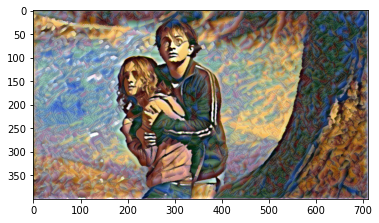

 33%|███▎      | 2007/6000 [02:00<05:50, 11.38it/s]

epoch  2010   

 34%|███▎      | 2016/6000 [02:00<05:09, 12.88it/s]

tensor(8.1731e+17, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▎      | 2019/6000 [02:00<04:47, 13.87it/s]

epoch  2020   

 34%|███▍      | 2026/6000 [02:01<04:18, 15.37it/s]

tensor(8.1670e+17, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 2029/6000 [02:01<04:11, 15.80it/s]

epoch  2030   

 34%|███▍      | 2036/6000 [02:01<04:00, 16.46it/s]

tensor(8.1609e+17, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 2039/6000 [02:02<03:58, 16.59it/s]

epoch  2040   

 34%|███▍      | 2046/6000 [02:02<03:54, 16.87it/s]

tensor(8.1548e+17, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 2049/6000 [02:02<03:53, 16.89it/s]

epoch  2050   

 34%|███▍      | 2056/6000 [02:03<03:51, 17.02it/s]

tensor(8.1488e+17, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 2059/6000 [02:03<03:51, 16.99it/s]

epoch  2060   

 34%|███▍      | 2066/6000 [02:03<04:21, 15.05it/s]

tensor(8.1429e+17, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 2069/6000 [02:03<04:12, 15.57it/s]

epoch  2070   

 35%|███▍      | 2076/6000 [02:04<04:00, 16.34it/s]

tensor(8.1370e+17, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▍      | 2079/6000 [02:04<03:57, 16.51it/s]

epoch  2080   

 35%|███▍      | 2086/6000 [02:04<03:52, 16.83it/s]

tensor(8.1313e+17, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▍      | 2089/6000 [02:05<03:52, 16.86it/s]

epoch  2090   

 35%|███▍      | 2096/6000 [02:05<03:49, 17.01it/s]

tensor(8.1255e+17, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▍      | 2099/6000 [02:05<03:49, 16.97it/s]

epoch  2100   

 35%|███▌      | 2106/6000 [02:06<04:18, 15.04it/s]

tensor(8.1198e+17, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 2109/6000 [02:06<04:10, 15.56it/s]

epoch  2110   

 35%|███▌      | 2116/6000 [02:06<03:57, 16.33it/s]

tensor(8.1142e+17, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 2119/6000 [02:06<03:55, 16.50it/s]

epoch  2120   

 35%|███▌      | 2126/6000 [02:07<03:50, 16.83it/s]

tensor(8.1087e+17, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 2129/6000 [02:07<03:49, 16.85it/s]

epoch  2130   

 36%|███▌      | 2136/6000 [02:07<03:47, 17.00it/s]

tensor(8.1032e+17, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 2139/6000 [02:08<03:47, 16.97it/s]

epoch  2140   

 36%|███▌      | 2146/6000 [02:08<03:45, 17.07it/s]

tensor(8.0978e+17, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 2149/6000 [02:08<03:46, 17.02it/s]

epoch  2150   

 36%|███▌      | 2156/6000 [02:09<04:15, 15.06it/s]

tensor(8.0924e+17, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 2159/6000 [02:09<04:06, 15.57it/s]

epoch  2160   

 36%|███▌      | 2166/6000 [02:09<03:54, 16.34it/s]

tensor(8.0871e+17, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 2169/6000 [02:09<03:52, 16.50it/s]

epoch  2170   

 36%|███▋      | 2176/6000 [02:10<03:47, 16.83it/s]

tensor(8.0818e+17, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▋      | 2179/6000 [02:10<03:46, 16.85it/s]

epoch  2180   

 36%|███▋      | 2186/6000 [02:10<03:44, 17.00it/s]

tensor(8.0766e+17, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▋      | 2189/6000 [02:11<03:44, 16.97it/s]

epoch  2190   

 37%|███▋      | 2196/6000 [02:11<04:12, 15.04it/s]

tensor(8.0714e+17, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 2199/6000 [02:11<04:04, 15.56it/s]

epoch  2200   

 37%|███▋      | 2206/6000 [02:12<03:52, 16.33it/s]

tensor(8.0663e+17, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 2209/6000 [02:12<03:49, 16.50it/s]

epoch  2210   

 37%|███▋      | 2216/6000 [02:12<03:44, 16.83it/s]

tensor(8.0612e+17, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 2219/6000 [02:12<03:44, 16.85it/s]

epoch  2220   

 37%|███▋      | 2226/6000 [02:13<03:42, 17.00it/s]

tensor(8.0562e+17, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 2229/6000 [02:13<03:42, 16.97it/s]

epoch  2230   

 37%|███▋      | 2236/6000 [02:13<03:40, 17.06it/s]

tensor(8.0512e+17, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 2239/6000 [02:13<03:41, 17.01it/s]

epoch  2240   

 37%|███▋      | 2246/6000 [02:14<04:09, 15.06it/s]

tensor(8.0463e+17, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 2249/6000 [02:14<04:00, 15.57it/s]

epoch  2250   

 38%|███▊      | 2256/6000 [02:15<03:49, 16.33it/s]

tensor(8.0414e+17, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 2259/6000 [02:15<03:46, 16.50it/s]

epoch  2260   

 38%|███▊      | 2266/6000 [02:15<03:41, 16.82it/s]

tensor(8.0366e+17, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 2269/6000 [02:15<03:41, 16.85it/s]

epoch  2270   

 38%|███▊      | 2276/6000 [02:16<03:39, 17.00it/s]

tensor(8.0318e+17, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 2279/6000 [02:16<03:39, 16.97it/s]

epoch  2280   

 38%|███▊      | 2286/6000 [02:16<03:37, 17.06it/s]

tensor(8.0270e+17, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 2289/6000 [02:16<03:38, 17.02it/s]

epoch  2290   

 38%|███▊      | 2296/6000 [02:17<04:06, 15.06it/s]

tensor(8.0223e+17, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 2299/6000 [02:17<03:57, 15.57it/s]

epoch  2300   

 38%|███▊      | 2306/6000 [02:17<03:46, 16.34it/s]

tensor(8.0177e+17, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 2309/6000 [02:18<03:43, 16.50it/s]

epoch  2310   

 39%|███▊      | 2316/6000 [02:18<03:38, 16.83it/s]

tensor(8.0132e+17, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▊      | 2319/6000 [02:18<03:38, 16.85it/s]

epoch  2320   

 39%|███▉      | 2326/6000 [02:19<03:36, 17.00it/s]

tensor(8.0086e+17, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▉      | 2329/6000 [02:19<03:36, 16.97it/s]

epoch  2330   

 39%|███▉      | 2336/6000 [02:19<04:03, 15.05it/s]

tensor(8.0042e+17, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▉      | 2339/6000 [02:19<03:55, 15.56it/s]

epoch  2340   

 39%|███▉      | 2346/6000 [02:20<03:43, 16.34it/s]

tensor(7.9997e+17, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▉      | 2349/6000 [02:20<03:41, 16.50it/s]

epoch  2350   

 39%|███▉      | 2356/6000 [02:20<03:36, 16.83it/s]

tensor(7.9953e+17, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▉      | 2359/6000 [02:21<03:36, 16.85it/s]

epoch  2360   

 39%|███▉      | 2366/6000 [02:21<03:33, 17.01it/s]

tensor(7.9909e+17, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▉      | 2369/6000 [02:21<03:33, 16.98it/s]

epoch  2370   

 40%|███▉      | 2376/6000 [02:22<04:00, 15.05it/s]

tensor(7.9866e+17, device='cuda:0', grad_fn=<AddBackward0>)


 40%|███▉      | 2379/6000 [02:22<03:52, 15.56it/s]

epoch  2380   

 40%|███▉      | 2386/6000 [02:22<03:41, 16.34it/s]

tensor(7.9823e+17, device='cuda:0', grad_fn=<AddBackward0>)


 40%|███▉      | 2389/6000 [02:22<03:38, 16.51it/s]

epoch  2390   

 40%|███▉      | 2396/6000 [02:23<03:34, 16.83it/s]

tensor(7.9780e+17, device='cuda:0', grad_fn=<AddBackward0>)


 40%|███▉      | 2399/6000 [02:23<03:33, 16.85it/s]

epoch  2400   

 40%|████      | 2406/6000 [02:23<03:31, 17.00it/s]

tensor(7.9737e+17, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 2409/6000 [02:24<03:31, 16.98it/s]

epoch  2410   

 40%|████      | 2416/6000 [02:24<03:58, 15.04it/s]

tensor(7.9694e+17, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 2419/6000 [02:24<03:50, 15.56it/s]

epoch  2420   

 40%|████      | 2426/6000 [02:25<03:38, 16.33it/s]

tensor(7.9652e+17, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 2429/6000 [02:25<03:36, 16.50it/s]

epoch  2430   

 41%|████      | 2436/6000 [02:25<03:31, 16.83it/s]

tensor(7.9611e+17, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████      | 2439/6000 [02:25<03:31, 16.85it/s]

epoch  2440   

 41%|████      | 2446/6000 [02:26<03:29, 17.00it/s]

tensor(7.9569e+17, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████      | 2449/6000 [02:26<03:29, 16.97it/s]

epoch  2450   

 41%|████      | 2456/6000 [02:26<03:55, 15.03it/s]

tensor(7.9529e+17, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████      | 2459/6000 [02:27<03:47, 15.55it/s]

epoch  2460   

 41%|████      | 2466/6000 [02:27<03:36, 16.33it/s]

tensor(7.9488e+17, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████      | 2469/6000 [02:27<03:34, 16.50it/s]

epoch  2470   

 41%|████▏     | 2476/6000 [02:28<03:29, 16.82it/s]

tensor(7.9448e+17, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████▏     | 2479/6000 [02:28<03:29, 16.85it/s]

epoch  2480   

 41%|████▏     | 2486/6000 [02:28<03:26, 17.01it/s]

tensor(7.9408e+17, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████▏     | 2489/6000 [02:28<03:26, 16.97it/s]

epoch  2490   

 42%|████▏     | 2496/6000 [02:29<03:52, 15.05it/s]

tensor(7.9368e+17, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 2499/6000 [02:29<03:44, 15.57it/s]

epoch  2500   tensor(7.9328e+17, device='cuda:0', grad_fn=<AddBackward0>)


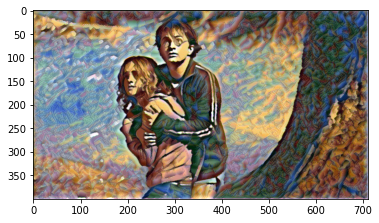

 42%|████▏     | 2507/6000 [02:30<05:07, 11.36it/s]

epoch  2510   

 42%|████▏     | 2516/6000 [02:30<04:30, 12.87it/s]

tensor(7.9290e+17, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 2519/6000 [02:30<04:11, 13.86it/s]

epoch  2520   

 42%|████▏     | 2526/6000 [02:31<03:46, 15.36it/s]

tensor(7.9251e+17, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 2529/6000 [02:31<03:39, 15.79it/s]

epoch  2530   

 42%|████▏     | 2536/6000 [02:31<03:30, 16.46it/s]

tensor(7.9213e+17, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 2539/6000 [02:32<03:28, 16.59it/s]

epoch  2540   

 42%|████▏     | 2546/6000 [02:32<03:24, 16.87it/s]

tensor(7.9175e+17, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 2549/6000 [02:32<03:24, 16.88it/s]

epoch  2550   

 43%|████▎     | 2556/6000 [02:33<03:22, 17.02it/s]

tensor(7.9138e+17, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 2559/6000 [02:33<03:22, 16.98it/s]

epoch  2560   

 43%|████▎     | 2566/6000 [02:33<03:48, 15.05it/s]

tensor(7.9101e+17, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 2569/6000 [02:33<03:40, 15.56it/s]

epoch  2570   

 43%|████▎     | 2576/6000 [02:34<03:29, 16.33it/s]

tensor(7.9063e+17, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 2579/6000 [02:34<03:27, 16.50it/s]

epoch  2580   

 43%|████▎     | 2586/6000 [02:34<03:22, 16.83it/s]

tensor(7.9027e+17, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 2589/6000 [02:35<03:22, 16.85it/s]

epoch  2590   

 43%|████▎     | 2596/6000 [02:35<03:20, 17.00it/s]

tensor(7.8991e+17, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 2599/6000 [02:35<03:20, 16.97it/s]

epoch  2600   

 43%|████▎     | 2606/6000 [02:36<03:18, 17.06it/s]

tensor(7.8955e+17, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 2609/6000 [02:36<03:19, 17.02it/s]

epoch  2610   

 44%|████▎     | 2616/6000 [02:36<03:18, 17.08it/s]

tensor(7.8920e+17, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▎     | 2619/6000 [02:36<03:18, 17.02it/s]

epoch  2620   

 44%|████▍     | 2626/6000 [02:37<03:44, 15.05it/s]

tensor(7.8884e+17, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 2629/6000 [02:37<03:36, 15.57it/s]

epoch  2630   

 44%|████▍     | 2636/6000 [02:37<03:25, 16.34it/s]

tensor(7.8849e+17, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 2639/6000 [02:38<03:23, 16.50it/s]

epoch  2640   

 44%|████▍     | 2646/6000 [02:38<03:19, 16.82it/s]

tensor(7.8815e+17, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 2649/6000 [02:38<03:18, 16.85it/s]

epoch  2650   

 44%|████▍     | 2656/6000 [02:39<03:16, 17.00it/s]

tensor(7.8780e+17, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 2659/6000 [02:39<03:16, 16.97it/s]

epoch  2660   

 44%|████▍     | 2666/6000 [02:39<03:41, 15.03it/s]

tensor(7.8745e+17, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 2669/6000 [02:39<03:34, 15.54it/s]

epoch  2670   

 45%|████▍     | 2676/6000 [02:40<03:23, 16.32it/s]

tensor(7.8711e+17, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▍     | 2679/6000 [02:40<03:21, 16.49it/s]

epoch  2680   

 45%|████▍     | 2686/6000 [02:40<03:17, 16.82it/s]

tensor(7.8677e+17, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▍     | 2689/6000 [02:41<03:16, 16.85it/s]

epoch  2690   

 45%|████▍     | 2696/6000 [02:41<03:14, 17.00it/s]

tensor(7.8643e+17, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▍     | 2699/6000 [02:41<03:14, 16.98it/s]

epoch  2700   

 45%|████▌     | 2706/6000 [02:42<03:38, 15.05it/s]

tensor(7.8610e+17, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▌     | 2709/6000 [02:42<03:31, 15.56it/s]

epoch  2710   

 45%|████▌     | 2716/6000 [02:42<03:21, 16.33it/s]

tensor(7.8577e+17, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▌     | 2719/6000 [02:42<03:18, 16.50it/s]

epoch  2720   

 45%|████▌     | 2726/6000 [02:43<03:14, 16.83it/s]

tensor(7.8545e+17, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▌     | 2729/6000 [02:43<03:14, 16.85it/s]

epoch  2730   

 46%|████▌     | 2736/6000 [02:43<03:11, 17.01it/s]

tensor(7.8512e+17, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 2739/6000 [02:44<03:12, 16.98it/s]

epoch  2740   

 46%|████▌     | 2746/6000 [02:44<03:10, 17.06it/s]

tensor(7.8480e+17, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 2749/6000 [02:44<03:11, 17.01it/s]

epoch  2750   

 46%|████▌     | 2756/6000 [02:45<03:35, 15.07it/s]

tensor(7.8447e+17, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 2759/6000 [02:45<03:28, 15.58it/s]

epoch  2760   

 46%|████▌     | 2766/6000 [02:45<03:17, 16.34it/s]

tensor(7.8415e+17, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 2769/6000 [02:45<03:15, 16.51it/s]

epoch  2770   

 46%|████▋     | 2776/6000 [02:46<03:11, 16.83it/s]

tensor(7.8384e+17, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▋     | 2779/6000 [02:46<03:11, 16.86it/s]

epoch  2780   

 46%|████▋     | 2786/6000 [02:46<03:09, 17.00it/s]

tensor(7.8353e+17, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▋     | 2789/6000 [02:46<03:09, 16.97it/s]

epoch  2790   

 47%|████▋     | 2796/6000 [02:47<03:32, 15.05it/s]

tensor(7.8323e+17, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 2799/6000 [02:47<03:25, 15.56it/s]

epoch  2800   

 47%|████▋     | 2806/6000 [02:47<03:15, 16.33it/s]

tensor(7.8292e+17, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 2809/6000 [02:48<03:13, 16.50it/s]

epoch  2810   

 47%|████▋     | 2816/6000 [02:48<03:09, 16.83it/s]

tensor(7.8261e+17, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 2819/6000 [02:48<03:08, 16.85it/s]

epoch  2820   

 47%|████▋     | 2826/6000 [02:49<03:06, 17.00it/s]

tensor(7.8232e+17, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 2829/6000 [02:49<03:06, 16.98it/s]

epoch  2830   

 47%|████▋     | 2836/6000 [02:49<03:30, 15.05it/s]

tensor(7.8202e+17, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 2839/6000 [02:49<03:23, 15.56it/s]

epoch  2840   

 47%|████▋     | 2846/6000 [02:50<03:13, 16.34it/s]

tensor(7.8173e+17, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 2849/6000 [02:50<03:10, 16.51it/s]

epoch  2850   

 48%|████▊     | 2856/6000 [02:50<03:06, 16.83it/s]

tensor(7.8144e+17, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 2859/6000 [02:51<03:06, 16.85it/s]

epoch  2860   

 48%|████▊     | 2866/6000 [02:51<03:04, 17.00it/s]

tensor(7.8115e+17, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 2869/6000 [02:51<03:04, 16.97it/s]

epoch  2870   

 48%|████▊     | 2876/6000 [02:52<03:27, 15.04it/s]

tensor(7.8086e+17, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 2879/6000 [02:52<03:20, 15.56it/s]

epoch  2880   

 48%|████▊     | 2886/6000 [02:52<03:10, 16.33it/s]

tensor(7.8057e+17, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 2889/6000 [02:52<03:08, 16.49it/s]

epoch  2890   

 48%|████▊     | 2896/6000 [02:53<03:04, 16.82it/s]

tensor(7.8029e+17, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 2899/6000 [02:53<03:04, 16.85it/s]

epoch  2900   

 48%|████▊     | 2906/6000 [02:53<03:01, 17.00it/s]

tensor(7.8002e+17, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 2909/6000 [02:54<03:02, 16.97it/s]

epoch  2910   

 49%|████▊     | 2916/6000 [02:54<03:25, 15.04it/s]

tensor(7.7974e+17, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▊     | 2919/6000 [02:54<03:18, 15.55it/s]

epoch  2920   

 49%|████▉     | 2926/6000 [02:55<03:08, 16.33it/s]

tensor(7.7947e+17, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▉     | 2929/6000 [02:55<03:06, 16.50it/s]

epoch  2930   

 49%|████▉     | 2936/6000 [02:55<03:02, 16.82it/s]

tensor(7.7920e+17, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▉     | 2939/6000 [02:55<03:01, 16.85it/s]

epoch  2940   

 49%|████▉     | 2946/6000 [02:56<02:59, 17.01it/s]

tensor(7.7893e+17, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▉     | 2949/6000 [02:56<02:59, 16.98it/s]

epoch  2950   

 49%|████▉     | 2956/6000 [02:56<03:22, 15.04it/s]

tensor(7.7867e+17, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▉     | 2959/6000 [02:57<03:15, 15.56it/s]

epoch  2960   

 49%|████▉     | 2966/6000 [02:57<03:05, 16.33it/s]

tensor(7.7840e+17, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▉     | 2969/6000 [02:57<03:03, 16.50it/s]

epoch  2970   

 50%|████▉     | 2976/6000 [02:58<02:59, 16.82it/s]

tensor(7.7814e+17, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████▉     | 2979/6000 [02:58<02:59, 16.85it/s]

epoch  2980   

 50%|████▉     | 2986/6000 [02:58<02:57, 17.00it/s]

tensor(7.7787e+17, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████▉     | 2989/6000 [02:58<02:57, 16.97it/s]

epoch  2990   

 50%|████▉     | 2996/6000 [02:59<03:19, 15.04it/s]

tensor(7.7762e+17, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████▉     | 2999/6000 [02:59<03:12, 15.56it/s]

epoch  3000   tensor(7.7736e+17, device='cuda:0', grad_fn=<AddBackward0>)


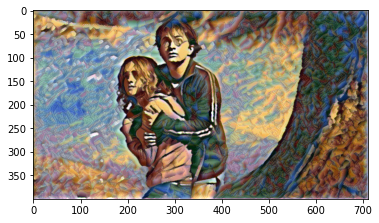

 50%|█████     | 3007/6000 [03:00<04:34, 10.91it/s]

epoch  3010   

 50%|█████     | 3016/6000 [03:00<03:57, 12.58it/s]

tensor(7.7710e+17, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 3019/6000 [03:01<03:38, 13.63it/s]

epoch  3020   

 50%|█████     | 3026/6000 [03:01<03:15, 15.22it/s]

tensor(7.7684e+17, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 3029/6000 [03:01<03:09, 15.69it/s]

epoch  3030   

 51%|█████     | 3036/6000 [03:02<03:00, 16.39it/s]

tensor(7.7659e+17, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 3039/6000 [03:02<02:59, 16.54it/s]

epoch  3040   

 51%|█████     | 3046/6000 [03:02<02:55, 16.84it/s]

tensor(7.7634e+17, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 3049/6000 [03:02<02:55, 16.86it/s]

epoch  3050   

 51%|█████     | 3056/6000 [03:03<02:53, 17.01it/s]

tensor(7.7609e+17, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 3059/6000 [03:03<02:53, 16.98it/s]

epoch  3060   

 51%|█████     | 3066/6000 [03:03<02:51, 17.06it/s]

tensor(7.7584e+17, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 3069/6000 [03:03<02:52, 17.01it/s]

epoch  3070   

 51%|█████▏    | 3076/6000 [03:04<03:14, 15.04it/s]

tensor(7.7559e+17, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████▏    | 3079/6000 [03:04<03:07, 15.55it/s]

epoch  3080   

 51%|█████▏    | 3086/6000 [03:04<02:58, 16.32it/s]

tensor(7.7534e+17, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████▏    | 3089/6000 [03:05<02:56, 16.49it/s]

epoch  3090   

 52%|█████▏    | 3096/6000 [03:05<02:52, 16.82it/s]

tensor(7.7509e+17, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 3099/6000 [03:05<02:52, 16.84it/s]

epoch  3100   

 52%|█████▏    | 3106/6000 [03:06<02:50, 16.99it/s]

tensor(7.7485e+17, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 3109/6000 [03:06<02:50, 16.97it/s]

epoch  3110   

 52%|█████▏    | 3116/6000 [03:06<02:49, 17.06it/s]

tensor(7.7460e+17, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 3119/6000 [03:06<02:49, 17.01it/s]

epoch  3120   

 52%|█████▏    | 3126/6000 [03:07<03:10, 15.05it/s]

tensor(7.7435e+17, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 3129/6000 [03:07<03:04, 15.57it/s]

epoch  3130   

 52%|█████▏    | 3136/6000 [03:07<02:55, 16.33it/s]

tensor(7.7410e+17, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 3139/6000 [03:08<02:53, 16.50it/s]

epoch  3140   

 52%|█████▏    | 3146/6000 [03:08<02:49, 16.83it/s]

tensor(7.7386e+17, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 3149/6000 [03:08<02:49, 16.85it/s]

epoch  3150   

 53%|█████▎    | 3156/6000 [03:09<02:47, 17.00it/s]

tensor(7.7361e+17, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 3159/6000 [03:09<02:47, 16.97it/s]

epoch  3160   

 53%|█████▎    | 3166/6000 [03:09<03:08, 15.04it/s]

tensor(7.7337e+17, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 3169/6000 [03:09<03:02, 15.55it/s]

epoch  3170   

 53%|█████▎    | 3176/6000 [03:10<02:53, 16.32it/s]

tensor(7.7314e+17, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 3179/6000 [03:10<02:51, 16.49it/s]

epoch  3180   

 53%|█████▎    | 3186/6000 [03:10<02:47, 16.82it/s]

tensor(7.7290e+17, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 3189/6000 [03:11<02:46, 16.85it/s]

epoch  3190   

 53%|█████▎    | 3196/6000 [03:11<02:44, 17.00it/s]

tensor(7.7266e+17, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 3199/6000 [03:11<02:45, 16.97it/s]

epoch  3200   

 53%|█████▎    | 3206/6000 [03:12<02:43, 17.06it/s]

tensor(7.7242e+17, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 3209/6000 [03:12<02:44, 17.01it/s]

epoch  3210   

 54%|█████▎    | 3216/6000 [03:12<02:42, 17.09it/s]

tensor(7.7219e+17, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▎    | 3219/6000 [03:12<02:43, 17.03it/s]

epoch  3220   

 54%|█████▍    | 3226/6000 [03:13<03:04, 15.06it/s]

tensor(7.7195e+17, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 3229/6000 [03:13<02:57, 15.57it/s]

epoch  3230   

 54%|█████▍    | 3236/6000 [03:13<02:49, 16.34it/s]

tensor(7.7172e+17, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 3239/6000 [03:14<02:47, 16.50it/s]

epoch  3240   

 54%|█████▍    | 3246/6000 [03:14<02:43, 16.83it/s]

tensor(7.7148e+17, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 3249/6000 [03:14<02:43, 16.85it/s]

epoch  3250   

 54%|█████▍    | 3256/6000 [03:15<02:41, 16.98it/s]

tensor(7.7125e+17, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 3259/6000 [03:15<02:41, 16.96it/s]

epoch  3260   

 54%|█████▍    | 3266/6000 [03:15<02:40, 17.06it/s]

tensor(7.7102e+17, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 3269/6000 [03:15<02:40, 17.01it/s]

epoch  3270   

 55%|█████▍    | 3276/6000 [03:16<03:00, 15.05it/s]

tensor(7.7079e+17, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▍    | 3279/6000 [03:16<02:54, 15.56it/s]

epoch  3280   

 55%|█████▍    | 3286/6000 [03:16<02:46, 16.33it/s]

tensor(7.7057e+17, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▍    | 3289/6000 [03:17<02:44, 16.50it/s]

epoch  3290   

 55%|█████▍    | 3296/6000 [03:17<02:40, 16.83it/s]

tensor(7.7034e+17, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▍    | 3299/6000 [03:17<02:40, 16.85it/s]

epoch  3300   

 55%|█████▌    | 3306/6000 [03:18<02:38, 17.00it/s]

tensor(7.7011e+17, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▌    | 3309/6000 [03:18<02:38, 16.97it/s]

epoch  3310   

 55%|█████▌    | 3316/6000 [03:18<02:58, 15.04it/s]

tensor(7.6989e+17, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▌    | 3319/6000 [03:18<02:52, 15.55it/s]

epoch  3320   

 55%|█████▌    | 3326/6000 [03:19<02:43, 16.33it/s]

tensor(7.6966e+17, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▌    | 3329/6000 [03:19<02:41, 16.50it/s]

epoch  3330   

 56%|█████▌    | 3336/6000 [03:19<02:38, 16.83it/s]

tensor(7.6944e+17, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 3339/6000 [03:19<02:37, 16.85it/s]

epoch  3340   

 56%|█████▌    | 3346/6000 [03:20<02:36, 17.00it/s]

tensor(7.6921e+17, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 3349/6000 [03:20<02:36, 16.98it/s]

epoch  3350   

 56%|█████▌    | 3356/6000 [03:21<02:55, 15.05it/s]

tensor(7.6900e+17, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 3359/6000 [03:21<02:49, 15.56it/s]

epoch  3360   

 56%|█████▌    | 3366/6000 [03:21<02:41, 16.34it/s]

tensor(7.6878e+17, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 3369/6000 [03:21<02:39, 16.50it/s]

epoch  3370   

 56%|█████▋    | 3376/6000 [03:22<02:35, 16.83it/s]

tensor(7.6855e+17, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▋    | 3379/6000 [03:22<02:35, 16.85it/s]

epoch  3380   

 56%|█████▋    | 3386/6000 [03:22<02:33, 17.00it/s]

tensor(7.6834e+17, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▋    | 3389/6000 [03:22<02:33, 16.97it/s]

epoch  3390   

 57%|█████▋    | 3396/6000 [03:23<02:53, 15.05it/s]

tensor(7.6812e+17, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 3399/6000 [03:23<02:47, 15.56it/s]

epoch  3400   

 57%|█████▋    | 3406/6000 [03:23<02:38, 16.33it/s]

tensor(7.6790e+17, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 3409/6000 [03:24<02:37, 16.50it/s]

epoch  3410   

 57%|█████▋    | 3416/6000 [03:24<02:33, 16.83it/s]

tensor(7.6769e+17, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 3419/6000 [03:24<02:33, 16.85it/s]

epoch  3420   

 57%|█████▋    | 3426/6000 [03:25<02:31, 17.00it/s]

tensor(7.6748e+17, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 3429/6000 [03:25<02:31, 16.98it/s]

epoch  3430   

 57%|█████▋    | 3436/6000 [03:25<02:50, 15.05it/s]

tensor(7.6727e+17, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 3439/6000 [03:25<02:44, 15.56it/s]

epoch  3440   

 57%|█████▋    | 3446/6000 [03:26<02:36, 16.33it/s]

tensor(7.6706e+17, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 3449/6000 [03:26<02:34, 16.50it/s]

epoch  3450   

 58%|█████▊    | 3456/6000 [03:26<02:31, 16.83it/s]

tensor(7.6685e+17, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 3459/6000 [03:27<02:30, 16.85it/s]

epoch  3460   

 58%|█████▊    | 3466/6000 [03:27<02:29, 17.01it/s]

tensor(7.6665e+17, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 3469/6000 [03:27<02:29, 16.97it/s]

epoch  3470   

 58%|█████▊    | 3476/6000 [03:28<02:27, 17.07it/s]

tensor(7.6645e+17, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 3479/6000 [03:28<02:28, 17.01it/s]

epoch  3480   

 58%|█████▊    | 3486/6000 [03:28<02:46, 15.06it/s]

tensor(7.6625e+17, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 3489/6000 [03:28<02:41, 15.57it/s]

epoch  3490   

 58%|█████▊    | 3496/6000 [03:29<02:33, 16.34it/s]

tensor(7.6604e+17, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 3499/6000 [03:29<02:31, 16.51it/s]

epoch  3500   tensor(7.6584e+17, device='cuda:0', grad_fn=<AddBackward0>)


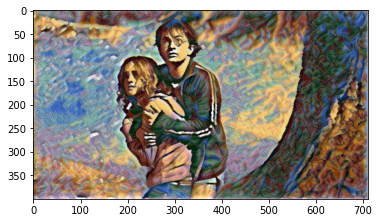

 58%|█████▊    | 3507/6000 [03:30<03:36, 11.50it/s]

epoch  3510   

 59%|█████▊    | 3516/6000 [03:30<03:11, 12.95it/s]

tensor(7.6564e+17, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▊    | 3519/6000 [03:31<02:58, 13.93it/s]

epoch  3520   

 59%|█████▉    | 3526/6000 [03:31<02:40, 15.40it/s]

tensor(7.6545e+17, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▉    | 3529/6000 [03:31<02:36, 15.82it/s]

epoch  3530   

 59%|█████▉    | 3536/6000 [03:32<02:29, 16.47it/s]

tensor(7.6525e+17, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▉    | 3539/6000 [03:32<02:28, 16.60it/s]

epoch  3540   

 59%|█████▉    | 3546/6000 [03:32<02:25, 16.87it/s]

tensor(7.6505e+17, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▉    | 3549/6000 [03:32<02:25, 16.88it/s]

epoch  3550   

 59%|█████▉    | 3556/6000 [03:33<02:23, 17.02it/s]

tensor(7.6486e+17, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▉    | 3559/6000 [03:33<02:23, 16.99it/s]

epoch  3560   

 59%|█████▉    | 3566/6000 [03:33<02:41, 15.05it/s]

tensor(7.6466e+17, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▉    | 3569/6000 [03:34<02:36, 15.57it/s]

epoch  3570   

 60%|█████▉    | 3576/6000 [03:34<02:28, 16.34it/s]

tensor(7.6448e+17, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████▉    | 3579/6000 [03:34<02:26, 16.50it/s]

epoch  3580   

 60%|█████▉    | 3586/6000 [03:35<02:23, 16.83it/s]

tensor(7.6429e+17, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████▉    | 3589/6000 [03:35<02:23, 16.85it/s]

epoch  3590   

 60%|█████▉    | 3596/6000 [03:35<02:21, 17.00it/s]

tensor(7.6411e+17, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████▉    | 3599/6000 [03:35<02:21, 16.97it/s]

epoch  3600   

 60%|██████    | 3606/6000 [03:36<02:39, 15.04it/s]

tensor(7.6393e+17, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 3609/6000 [03:36<02:33, 15.55it/s]

epoch  3610   

 60%|██████    | 3616/6000 [03:36<02:25, 16.33it/s]

tensor(7.6375e+17, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 3619/6000 [03:36<02:24, 16.50it/s]

epoch  3620   

 60%|██████    | 3626/6000 [03:37<02:21, 16.83it/s]

tensor(7.6356e+17, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 3629/6000 [03:37<02:20, 16.85it/s]

epoch  3630   

 61%|██████    | 3636/6000 [03:37<02:19, 17.01it/s]

tensor(7.6338e+17, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 3639/6000 [03:38<02:19, 16.97it/s]

epoch  3640   

 61%|██████    | 3646/6000 [03:38<02:36, 15.01it/s]

tensor(7.6320e+17, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 3649/6000 [03:38<02:31, 15.53it/s]

epoch  3650   

 61%|██████    | 3656/6000 [03:39<02:23, 16.32it/s]

tensor(7.6302e+17, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 3659/6000 [03:39<02:21, 16.49it/s]

epoch  3660   

 61%|██████    | 3666/6000 [03:39<02:18, 16.82it/s]

tensor(7.6284e+17, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 3669/6000 [03:39<02:18, 16.85it/s]

epoch  3670   

 61%|██████▏   | 3676/6000 [03:40<02:16, 17.00it/s]

tensor(7.6266e+17, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████▏   | 3679/6000 [03:40<02:16, 16.98it/s]

epoch  3680   

 61%|██████▏   | 3686/6000 [03:40<02:15, 17.07it/s]

tensor(7.6249e+17, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████▏   | 3689/6000 [03:41<02:15, 17.02it/s]

epoch  3690   

 62%|██████▏   | 3696/6000 [03:41<02:14, 17.08it/s]

tensor(7.6231e+17, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 3699/6000 [03:41<02:15, 17.03it/s]

epoch  3700   

 62%|██████▏   | 3706/6000 [03:42<02:32, 15.08it/s]

tensor(7.6214e+17, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 3709/6000 [03:42<02:27, 15.58it/s]

epoch  3710   

 62%|██████▏   | 3716/6000 [03:42<02:19, 16.35it/s]

tensor(7.6196e+17, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 3719/6000 [03:42<02:18, 16.51it/s]

epoch  3720   

 62%|██████▏   | 3726/6000 [03:43<02:15, 16.83it/s]

tensor(7.6179e+17, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 3729/6000 [03:43<02:14, 16.85it/s]

epoch  3730   

 62%|██████▏   | 3736/6000 [03:43<02:13, 17.01it/s]

tensor(7.6161e+17, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 3739/6000 [03:44<02:13, 16.98it/s]

epoch  3740   

 62%|██████▏   | 3746/6000 [03:44<02:29, 15.04it/s]

tensor(7.6144e+17, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 3749/6000 [03:44<02:24, 15.56it/s]

epoch  3750   

 63%|██████▎   | 3756/6000 [03:45<02:17, 16.33it/s]

tensor(7.6126e+17, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 3759/6000 [03:45<02:15, 16.51it/s]

epoch  3760   

 63%|██████▎   | 3766/6000 [03:45<02:12, 16.84it/s]

tensor(7.6109e+17, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 3769/6000 [03:45<02:12, 16.86it/s]

epoch  3770   

 63%|██████▎   | 3776/6000 [03:46<02:10, 17.01it/s]

tensor(7.6092e+17, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 3779/6000 [03:46<02:10, 16.98it/s]

epoch  3780   

 63%|██████▎   | 3786/6000 [03:46<02:09, 17.07it/s]

tensor(7.6075e+17, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 3789/6000 [03:47<02:09, 17.01it/s]

epoch  3790   

 63%|██████▎   | 3796/6000 [03:47<02:26, 15.07it/s]

tensor(7.6058e+17, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 3799/6000 [03:47<02:21, 15.58it/s]

epoch  3800   

 63%|██████▎   | 3806/6000 [03:48<02:14, 16.34it/s]

tensor(7.6041e+17, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 3809/6000 [03:48<02:12, 16.51it/s]

epoch  3810   

 64%|██████▎   | 3816/6000 [03:48<02:09, 16.83it/s]

tensor(7.6024e+17, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▎   | 3819/6000 [03:48<02:09, 16.85it/s]

epoch  3820   

 64%|██████▍   | 3826/6000 [03:49<02:07, 17.00it/s]

tensor(7.6007e+17, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 3829/6000 [03:49<02:07, 16.97it/s]

epoch  3830   

 64%|██████▍   | 3836/6000 [03:49<02:23, 15.04it/s]

tensor(7.5990e+17, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 3839/6000 [03:50<02:18, 15.56it/s]

epoch  3840   

 64%|██████▍   | 3846/6000 [03:50<02:11, 16.33it/s]

tensor(7.5974e+17, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 3849/6000 [03:50<02:10, 16.50it/s]

epoch  3850   

 64%|██████▍   | 3856/6000 [03:51<02:07, 16.82it/s]

tensor(7.5957e+17, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 3859/6000 [03:51<02:07, 16.85it/s]

epoch  3860   

 64%|██████▍   | 3866/6000 [03:51<02:05, 17.00it/s]

tensor(7.5941e+17, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 3869/6000 [03:51<02:05, 16.97it/s]

epoch  3870   

 65%|██████▍   | 3876/6000 [03:52<02:21, 15.05it/s]

tensor(7.5924e+17, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▍   | 3879/6000 [03:52<02:16, 15.57it/s]

epoch  3880   

 65%|██████▍   | 3886/6000 [03:52<02:09, 16.34it/s]

tensor(7.5908e+17, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▍   | 3889/6000 [03:52<02:07, 16.50it/s]

epoch  3890   

 65%|██████▍   | 3896/6000 [03:53<02:04, 16.83it/s]

tensor(7.5896e+17, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▍   | 3899/6000 [03:53<02:04, 16.86it/s]

epoch  3900   

 65%|██████▌   | 3906/6000 [03:53<02:03, 17.01it/s]

tensor(7.5885e+17, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 3909/6000 [03:54<02:03, 16.98it/s]

epoch  3910   

 65%|██████▌   | 3916/6000 [03:54<02:18, 15.05it/s]

tensor(7.5864e+17, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 3919/6000 [03:54<02:13, 15.56it/s]

epoch  3920   

 65%|██████▌   | 3926/6000 [03:55<02:06, 16.34it/s]

tensor(7.5853e+17, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 3929/6000 [03:55<02:05, 16.50it/s]

epoch  3930   

 66%|██████▌   | 3936/6000 [03:55<02:02, 16.83it/s]

tensor(7.5838e+17, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 3939/6000 [03:55<02:02, 16.85it/s]

epoch  3940   

 66%|██████▌   | 3946/6000 [03:56<02:00, 17.00it/s]

tensor(7.5820e+17, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 3949/6000 [03:56<02:00, 16.97it/s]

epoch  3950   

 66%|██████▌   | 3956/6000 [03:56<02:15, 15.05it/s]

tensor(7.5807e+17, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 3959/6000 [03:57<02:11, 15.57it/s]

epoch  3960   

 66%|██████▌   | 3966/6000 [03:57<02:04, 16.33it/s]

tensor(7.5787e+17, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 3969/6000 [03:57<02:03, 16.49it/s]

epoch  3970   

 66%|██████▋   | 3976/6000 [03:58<02:00, 16.82it/s]

tensor(7.5779e+17, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▋   | 3979/6000 [03:58<01:59, 16.85it/s]

epoch  3980   

 66%|██████▋   | 3986/6000 [03:58<01:58, 17.00it/s]

tensor(7.5757e+17, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▋   | 3989/6000 [03:58<01:58, 16.97it/s]

epoch  3990   

 67%|██████▋   | 3996/6000 [03:59<01:57, 17.06it/s]

tensor(7.5751e+17, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 3999/6000 [03:59<01:57, 17.01it/s]

epoch  4000   tensor(7.5723e+17, device='cuda:0', grad_fn=<AddBackward0>)


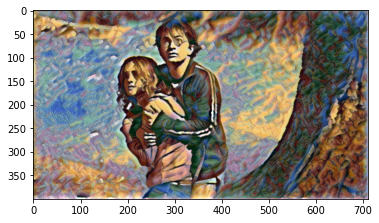

 67%|██████▋   | 4009/6000 [04:00<03:02, 10.92it/s]

epoch  4010   

 67%|██████▋   | 4016/6000 [04:00<02:27, 13.41it/s]

tensor(7.5723e+17, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 4019/6000 [04:01<02:18, 14.29it/s]

epoch  4020   

 67%|██████▋   | 4026/6000 [04:01<02:06, 15.62it/s]

tensor(7.5691e+17, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 4029/6000 [04:01<02:03, 15.98it/s]

epoch  4030   

 67%|██████▋   | 4036/6000 [04:02<01:58, 16.56it/s]

tensor(7.5689e+17, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 4039/6000 [04:02<01:57, 16.66it/s]

epoch  4040   

 67%|██████▋   | 4046/6000 [04:02<01:55, 16.90it/s]

tensor(7.5661e+17, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 4049/6000 [04:02<01:55, 16.91it/s]

epoch  4050   

 68%|██████▊   | 4056/6000 [04:03<02:09, 15.02it/s]

tensor(7.5637e+17, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 4059/6000 [04:03<02:04, 15.54it/s]

epoch  4060   

 68%|██████▊   | 4066/6000 [04:03<01:58, 16.32it/s]

tensor(7.5649e+17, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 4069/6000 [04:04<01:57, 16.49it/s]

epoch  4070   

 68%|██████▊   | 4076/6000 [04:04<01:54, 16.83it/s]

tensor(7.5614e+17, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 4079/6000 [04:04<01:54, 16.85it/s]

epoch  4080   

 68%|██████▊   | 4086/6000 [04:05<01:52, 17.01it/s]

tensor(7.5633e+17, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 4089/6000 [04:05<01:52, 16.97it/s]

epoch  4090   

 68%|██████▊   | 4096/6000 [04:05<02:06, 15.05it/s]

tensor(7.5586e+17, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 4099/6000 [04:05<02:02, 15.56it/s]

epoch  4100   

 68%|██████▊   | 4106/6000 [04:06<01:55, 16.33it/s]

tensor(7.5584e+17, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 4109/6000 [04:06<01:54, 16.50it/s]

epoch  4110   

 69%|██████▊   | 4116/6000 [04:06<01:51, 16.82it/s]

tensor(7.5554e+17, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▊   | 4119/6000 [04:06<01:51, 16.85it/s]

epoch  4120   

 69%|██████▉   | 4126/6000 [04:07<01:50, 17.00it/s]

tensor(7.5556e+17, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▉   | 4129/6000 [04:07<01:50, 16.98it/s]

epoch  4130   

 69%|██████▉   | 4136/6000 [04:07<01:49, 17.06it/s]

tensor(7.5524e+17, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▉   | 4139/6000 [04:08<01:49, 17.02it/s]

epoch  4140   

 69%|██████▉   | 4146/6000 [04:08<02:03, 15.05it/s]

tensor(7.5531e+17, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▉   | 4149/6000 [04:08<01:58, 15.56it/s]

epoch  4150   

 69%|██████▉   | 4156/6000 [04:09<01:52, 16.33it/s]

tensor(7.5507e+17, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▉   | 4159/6000 [04:09<01:51, 16.50it/s]

epoch  4160   

 69%|██████▉   | 4166/6000 [04:09<01:48, 16.83it/s]

tensor(7.5490e+17, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▉   | 4169/6000 [04:09<01:48, 16.85it/s]

epoch  4170   

 70%|██████▉   | 4176/6000 [04:10<01:47, 17.00it/s]

tensor(7.5482e+17, device='cuda:0', grad_fn=<AddBackward0>)


 70%|██████▉   | 4179/6000 [04:10<01:47, 16.97it/s]

epoch  4180   

 70%|██████▉   | 4186/6000 [04:10<02:00, 15.05it/s]

tensor(7.5489e+17, device='cuda:0', grad_fn=<AddBackward0>)


 70%|██████▉   | 4189/6000 [04:11<01:56, 15.56it/s]

epoch  4190   

 70%|██████▉   | 4196/6000 [04:11<01:50, 16.33it/s]

tensor(7.5437e+17, device='cuda:0', grad_fn=<AddBackward0>)


 70%|██████▉   | 4199/6000 [04:11<01:49, 16.50it/s]

epoch  4200   

 70%|███████   | 4206/6000 [04:12<01:46, 16.82it/s]

tensor(7.5462e+17, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 4209/6000 [04:12<01:46, 16.85it/s]

epoch  4210   

 70%|███████   | 4216/6000 [04:12<01:44, 17.00it/s]

tensor(7.5429e+17, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 4219/6000 [04:12<01:44, 16.97it/s]

epoch  4220   

 70%|███████   | 4226/6000 [04:13<01:57, 15.05it/s]

tensor(7.5446e+17, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 4229/6000 [04:13<01:53, 15.56it/s]

epoch  4230   

 71%|███████   | 4236/6000 [04:13<01:48, 16.33it/s]

tensor(7.5389e+17, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 4239/6000 [04:14<01:46, 16.50it/s]

epoch  4240   

 71%|███████   | 4246/6000 [04:14<01:44, 16.83it/s]

tensor(7.5390e+17, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 4249/6000 [04:14<01:43, 16.85it/s]

epoch  4250   

 71%|███████   | 4256/6000 [04:15<01:42, 17.01it/s]

tensor(7.5365e+17, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 4259/6000 [04:15<01:42, 16.98it/s]

epoch  4260   

 71%|███████   | 4266/6000 [04:15<01:55, 15.05it/s]

tensor(7.5362e+17, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 4269/6000 [04:15<01:51, 15.56it/s]

epoch  4270   

 71%|███████▏  | 4276/6000 [04:16<01:45, 16.33it/s]

tensor(7.5374e+17, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████▏  | 4279/6000 [04:16<01:44, 16.50it/s]

epoch  4280   

 71%|███████▏  | 4286/6000 [04:16<01:41, 16.82it/s]

tensor(7.5323e+17, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████▏  | 4289/6000 [04:17<01:41, 16.85it/s]

epoch  4290   

 72%|███████▏  | 4296/6000 [04:17<01:40, 17.00it/s]

tensor(7.5330e+17, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 4299/6000 [04:17<01:40, 16.97it/s]

epoch  4300   

 72%|███████▏  | 4306/6000 [04:18<01:52, 15.05it/s]

tensor(7.5294e+17, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 4309/6000 [04:18<01:48, 15.57it/s]

epoch  4310   

 72%|███████▏  | 4316/6000 [04:18<01:43, 16.34it/s]

tensor(7.5312e+17, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 4319/6000 [04:18<01:41, 16.50it/s]

epoch  4320   

 72%|███████▏  | 4326/6000 [04:19<01:39, 16.83it/s]

tensor(7.5290e+17, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 4329/6000 [04:19<01:39, 16.85it/s]

epoch  4330   

 72%|███████▏  | 4336/6000 [04:19<01:37, 17.00it/s]

tensor(7.5297e+17, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 4339/6000 [04:20<01:37, 16.97it/s]

epoch  4340   

 72%|███████▏  | 4346/6000 [04:20<01:49, 15.05it/s]

tensor(7.5275e+17, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 4349/6000 [04:20<01:46, 15.56it/s]

epoch  4350   

 73%|███████▎  | 4356/6000 [04:21<01:40, 16.34it/s]

tensor(7.5279e+17, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 4359/6000 [04:21<01:39, 16.50it/s]

epoch  4360   

 73%|███████▎  | 4366/6000 [04:21<01:37, 16.83it/s]

tensor(7.5242e+17, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 4369/6000 [04:21<01:36, 16.85it/s]

epoch  4370   

 73%|███████▎  | 4376/6000 [04:22<01:35, 17.00it/s]

tensor(7.5245e+17, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 4379/6000 [04:22<01:35, 16.97it/s]

epoch  4380   

 73%|███████▎  | 4386/6000 [04:22<01:47, 15.01it/s]

tensor(7.5200e+17, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 4389/6000 [04:22<01:43, 15.54it/s]

epoch  4390   

 73%|███████▎  | 4396/6000 [04:23<01:38, 16.32it/s]

tensor(7.5190e+17, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 4399/6000 [04:23<01:37, 16.49it/s]

epoch  4400   

 73%|███████▎  | 4406/6000 [04:23<01:34, 16.82it/s]

tensor(7.5181e+17, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 4409/6000 [04:24<01:34, 16.85it/s]

epoch  4410   

 74%|███████▎  | 4416/6000 [04:24<01:33, 17.00it/s]

tensor(7.5173e+17, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▎  | 4419/6000 [04:24<01:33, 16.98it/s]

epoch  4420   

 74%|███████▍  | 4426/6000 [04:25<01:44, 15.05it/s]

tensor(7.5208e+17, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 4429/6000 [04:25<01:40, 15.56it/s]

epoch  4430   

 74%|███████▍  | 4436/6000 [04:25<01:35, 16.34it/s]

tensor(7.5160e+17, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 4439/6000 [04:25<01:34, 16.50it/s]

epoch  4440   

 74%|███████▍  | 4446/6000 [04:26<01:32, 16.83it/s]

tensor(7.5180e+17, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 4449/6000 [04:26<01:32, 16.85it/s]

epoch  4450   

 74%|███████▍  | 4456/6000 [04:26<01:30, 17.00it/s]

tensor(7.5124e+17, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 4459/6000 [04:27<01:30, 16.97it/s]

epoch  4460   

 74%|███████▍  | 4466/6000 [04:27<01:42, 15.03it/s]

tensor(7.5132e+17, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 4469/6000 [04:27<01:38, 15.55it/s]

epoch  4470   

 75%|███████▍  | 4476/6000 [04:28<01:33, 16.32it/s]

tensor(7.5085e+17, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▍  | 4479/6000 [04:28<01:32, 16.49it/s]

epoch  4480   

 75%|███████▍  | 4486/6000 [04:28<01:30, 16.81it/s]

tensor(7.5088e+17, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▍  | 4489/6000 [04:28<01:29, 16.84it/s]

epoch  4490   

 75%|███████▍  | 4496/6000 [04:29<01:28, 17.00it/s]

tensor(7.5080e+17, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▍  | 4499/6000 [04:29<01:28, 16.97it/s]

epoch  4500   tensor(7.5084e+17, device='cuda:0', grad_fn=<AddBackward0>)


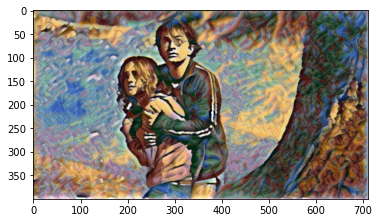

 75%|███████▌  | 4509/6000 [04:30<02:14, 11.07it/s]

epoch  4510   

 75%|███████▌  | 4516/6000 [04:30<01:49, 13.52it/s]

tensor(7.5079e+17, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▌  | 4519/6000 [04:31<01:42, 14.38it/s]

epoch  4520   

 75%|███████▌  | 4526/6000 [04:31<01:34, 15.67it/s]

tensor(7.5055e+17, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▌  | 4529/6000 [04:31<01:31, 16.02it/s]

epoch  4530   

 76%|███████▌  | 4536/6000 [04:32<01:28, 16.58it/s]

tensor(7.5083e+17, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 4539/6000 [04:32<01:27, 16.67it/s]

epoch  4540   

 76%|███████▌  | 4546/6000 [04:32<01:25, 16.91it/s]

tensor(7.5026e+17, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 4549/6000 [04:32<01:25, 16.91it/s]

epoch  4550   

 76%|███████▌  | 4556/6000 [04:33<01:36, 15.02it/s]

tensor(7.5056e+17, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 4559/6000 [04:33<01:32, 15.54it/s]

epoch  4560   

 76%|███████▌  | 4566/6000 [04:33<01:27, 16.32it/s]

tensor(7.5003e+17, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 4569/6000 [04:34<01:26, 16.49it/s]

epoch  4570   

 76%|███████▋  | 4576/6000 [04:34<01:24, 16.82it/s]

tensor(7.5017e+17, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▋  | 4579/6000 [04:34<01:24, 16.85it/s]

epoch  4580   

 76%|███████▋  | 4586/6000 [04:35<01:23, 17.00it/s]

tensor(7.5010e+17, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▋  | 4589/6000 [04:35<01:23, 16.97it/s]

epoch  4590   

 77%|███████▋  | 4596/6000 [04:35<01:33, 15.03it/s]

tensor(7.4971e+17, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 4599/6000 [04:35<01:30, 15.55it/s]

epoch  4600   

 77%|███████▋  | 4606/6000 [04:36<01:25, 16.33it/s]

tensor(7.4979e+17, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 4609/6000 [04:36<01:24, 16.49it/s]

epoch  4610   

 77%|███████▋  | 4616/6000 [04:36<01:22, 16.82it/s]

tensor(7.4932e+17, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 4619/6000 [04:36<01:21, 16.84it/s]

epoch  4620   

 77%|███████▋  | 4626/6000 [04:37<01:20, 16.99it/s]

tensor(7.4921e+17, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 4629/6000 [04:37<01:20, 16.96it/s]

epoch  4630   

 77%|███████▋  | 4636/6000 [04:37<01:30, 15.01it/s]

tensor(7.4936e+17, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 4639/6000 [04:38<01:27, 15.53it/s]

epoch  4640   

 77%|███████▋  | 4646/6000 [04:38<01:22, 16.32it/s]

tensor(7.4913e+17, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 4649/6000 [04:38<01:21, 16.49it/s]

epoch  4650   

 78%|███████▊  | 4656/6000 [04:39<01:19, 16.82it/s]

tensor(7.4920e+17, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 4659/6000 [04:39<01:19, 16.85it/s]

epoch  4660   

 78%|███████▊  | 4666/6000 [04:39<01:18, 17.00it/s]

tensor(7.4899e+17, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 4669/6000 [04:39<01:18, 16.97it/s]

epoch  4670   

 78%|███████▊  | 4676/6000 [04:40<01:27, 15.05it/s]

tensor(7.4938e+17, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 4679/6000 [04:40<01:24, 15.56it/s]

epoch  4680   

 78%|███████▊  | 4686/6000 [04:40<01:20, 16.33it/s]

tensor(7.4891e+17, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 4689/6000 [04:41<01:19, 16.50it/s]

epoch  4690   

 78%|███████▊  | 4696/6000 [04:41<01:17, 16.83it/s]

tensor(7.4920e+17, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 4699/6000 [04:41<01:17, 16.85it/s]

epoch  4700   

 78%|███████▊  | 4706/6000 [04:42<01:16, 17.00it/s]

tensor(7.4868e+17, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 4709/6000 [04:42<01:16, 16.97it/s]

epoch  4710   

 79%|███████▊  | 4716/6000 [04:42<01:25, 15.02it/s]

tensor(7.4889e+17, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▊  | 4719/6000 [04:42<01:22, 15.54it/s]

epoch  4720   

 79%|███████▉  | 4726/6000 [04:43<01:18, 16.32it/s]

tensor(7.4843e+17, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▉  | 4729/6000 [04:43<01:17, 16.49it/s]

epoch  4730   

 79%|███████▉  | 4736/6000 [04:43<01:15, 16.82it/s]

tensor(7.4858e+17, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▉  | 4739/6000 [04:44<01:14, 16.85it/s]

epoch  4740   

 79%|███████▉  | 4746/6000 [04:44<01:13, 17.00it/s]

tensor(7.4829e+17, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▉  | 4749/6000 [04:44<01:13, 16.97it/s]

epoch  4750   

 79%|███████▉  | 4756/6000 [04:45<01:22, 15.05it/s]

tensor(7.4862e+17, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▉  | 4759/6000 [04:45<01:19, 15.56it/s]

epoch  4760   

 79%|███████▉  | 4766/6000 [04:45<01:15, 16.33it/s]

tensor(7.4802e+17, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▉  | 4769/6000 [04:45<01:14, 16.50it/s]

epoch  4770   

 80%|███████▉  | 4776/6000 [04:46<01:12, 16.83it/s]

tensor(7.4824e+17, device='cuda:0', grad_fn=<AddBackward0>)


 80%|███████▉  | 4779/6000 [04:46<01:12, 16.85it/s]

epoch  4780   

 80%|███████▉  | 4786/6000 [04:46<01:11, 17.00it/s]

tensor(7.4767e+17, device='cuda:0', grad_fn=<AddBackward0>)


 80%|███████▉  | 4789/6000 [04:47<01:11, 16.97it/s]

epoch  4790   

 80%|███████▉  | 4796/6000 [04:47<01:19, 15.05it/s]

tensor(7.4789e+17, device='cuda:0', grad_fn=<AddBackward0>)


 80%|███████▉  | 4799/6000 [04:47<01:17, 15.56it/s]

epoch  4800   

 80%|████████  | 4806/6000 [04:48<01:13, 16.33it/s]

tensor(7.4737e+17, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 4809/6000 [04:48<01:12, 16.50it/s]

epoch  4810   

 80%|████████  | 4816/6000 [04:48<01:10, 16.83it/s]

tensor(7.4760e+17, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 4819/6000 [04:48<01:10, 16.85it/s]

epoch  4820   

 80%|████████  | 4826/6000 [04:49<01:09, 17.00it/s]

tensor(7.4717e+17, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 4829/6000 [04:49<01:08, 16.98it/s]

epoch  4830   

 81%|████████  | 4836/6000 [04:49<01:17, 15.05it/s]

tensor(7.4754e+17, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 4839/6000 [04:50<01:14, 15.56it/s]

epoch  4840   

 81%|████████  | 4846/6000 [04:50<01:10, 16.34it/s]

tensor(7.4708e+17, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 4849/6000 [04:50<01:09, 16.50it/s]

epoch  4850   

 81%|████████  | 4856/6000 [04:51<01:07, 16.83it/s]

tensor(7.4708e+17, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 4859/6000 [04:51<01:07, 16.85it/s]

epoch  4860   

 81%|████████  | 4866/6000 [04:51<01:06, 17.00it/s]

tensor(7.4708e+17, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 4869/6000 [04:51<01:06, 16.97it/s]

epoch  4870   

 81%|████████▏ | 4876/6000 [04:52<01:14, 15.05it/s]

tensor(7.4679e+17, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████▏ | 4879/6000 [04:52<01:12, 15.56it/s]

epoch  4880   

 81%|████████▏ | 4886/6000 [04:52<01:08, 16.33it/s]

tensor(7.4688e+17, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████▏ | 4889/6000 [04:52<01:07, 16.50it/s]

epoch  4890   

 82%|████████▏ | 4896/6000 [04:53<01:05, 16.83it/s]

tensor(7.4713e+17, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 4899/6000 [04:53<01:05, 16.85it/s]

epoch  4900   

 82%|████████▏ | 4906/6000 [04:53<01:04, 17.00it/s]

tensor(7.4677e+17, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 4909/6000 [04:54<01:04, 16.97it/s]

epoch  4910   

 82%|████████▏ | 4916/6000 [04:54<01:12, 15.04it/s]

tensor(7.4686e+17, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 4919/6000 [04:54<01:09, 15.56it/s]

epoch  4920   

 82%|████████▏ | 4926/6000 [04:55<01:05, 16.34it/s]

tensor(7.4684e+17, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 4929/6000 [04:55<01:04, 16.51it/s]

epoch  4930   

 82%|████████▏ | 4936/6000 [04:55<01:03, 16.83it/s]

tensor(7.4720e+17, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 4939/6000 [04:55<01:02, 16.85it/s]

epoch  4940   

 82%|████████▏ | 4946/6000 [04:56<01:01, 17.01it/s]

tensor(7.4661e+17, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 4949/6000 [04:56<01:01, 16.98it/s]

epoch  4950   

 83%|████████▎ | 4956/6000 [04:56<01:01, 17.07it/s]

tensor(7.4662e+17, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 4959/6000 [04:57<01:01, 17.02it/s]

epoch  4960   

 83%|████████▎ | 4966/6000 [04:57<01:08, 15.06it/s]

tensor(7.4624e+17, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 4969/6000 [04:57<01:06, 15.57it/s]

epoch  4970   

 83%|████████▎ | 4976/6000 [04:58<01:02, 16.34it/s]

tensor(7.4658e+17, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 4979/6000 [04:58<01:01, 16.50it/s]

epoch  4980   

 83%|████████▎ | 4986/6000 [04:58<01:00, 16.83it/s]

tensor(7.4604e+17, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 4989/6000 [04:58<00:59, 16.86it/s]

epoch  4990   

 83%|████████▎ | 4996/6000 [04:59<00:59, 17.01it/s]

tensor(7.4596e+17, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 4999/6000 [04:59<00:58, 16.98it/s]

epoch  5000   tensor(7.4590e+17, device='cuda:0', grad_fn=<AddBackward0>)


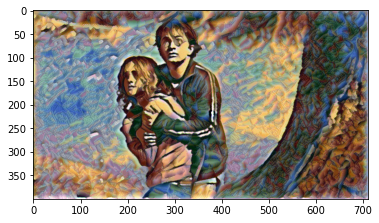

 83%|████████▎ | 5007/6000 [05:00<01:25, 11.66it/s]

epoch  5010   

 84%|████████▎ | 5016/6000 [05:00<01:15, 13.05it/s]

tensor(7.4590e+17, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▎ | 5019/6000 [05:01<01:10, 14.01it/s]

epoch  5020   

 84%|████████▍ | 5026/6000 [05:01<01:03, 15.46it/s]

tensor(7.4566e+17, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 5029/6000 [05:01<01:01, 15.86it/s]

epoch  5030   

 84%|████████▍ | 5036/6000 [05:02<00:58, 16.50it/s]

tensor(7.4580e+17, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 5039/6000 [05:02<00:57, 16.62it/s]

epoch  5040   

 84%|████████▍ | 5046/6000 [05:02<00:56, 16.89it/s]

tensor(7.4548e+17, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 5049/6000 [05:02<00:56, 16.89it/s]

epoch  5050   

 84%|████████▍ | 5056/6000 [05:03<00:55, 17.02it/s]

tensor(7.4523e+17, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 5059/6000 [05:03<00:55, 16.99it/s]

epoch  5060   

 84%|████████▍ | 5066/6000 [05:03<01:02, 15.05it/s]

tensor(7.4559e+17, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 5069/6000 [05:04<00:59, 15.57it/s]

epoch  5070   

 85%|████████▍ | 5076/6000 [05:04<00:56, 16.33it/s]

tensor(7.4555e+17, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▍ | 5079/6000 [05:04<00:55, 16.50it/s]

epoch  5080   

 85%|████████▍ | 5086/6000 [05:05<00:54, 16.83it/s]

tensor(7.4508e+17, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▍ | 5089/6000 [05:05<00:54, 16.85it/s]

epoch  5090   

 85%|████████▍ | 5096/6000 [05:05<00:53, 17.00it/s]

tensor(7.4516e+17, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▍ | 5099/6000 [05:05<00:53, 16.97it/s]

epoch  5100   

 85%|████████▌ | 5106/6000 [05:06<00:52, 17.06it/s]

tensor(7.4504e+17, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 5109/6000 [05:06<00:52, 17.01it/s]

epoch  5110   

 85%|████████▌ | 5116/6000 [05:06<00:58, 15.06it/s]

tensor(7.4474e+17, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 5119/6000 [05:06<00:56, 15.57it/s]

epoch  5120   

 85%|████████▌ | 5126/6000 [05:07<00:53, 16.34it/s]

tensor(7.4488e+17, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 5129/6000 [05:07<00:52, 16.51it/s]

epoch  5130   

 86%|████████▌ | 5136/6000 [05:07<00:51, 16.83it/s]

tensor(7.4465e+17, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 5139/6000 [05:08<00:51, 16.85it/s]

epoch  5140   

 86%|████████▌ | 5146/6000 [05:08<00:50, 17.00it/s]

tensor(7.4506e+17, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 5149/6000 [05:08<00:50, 16.98it/s]

epoch  5150   

 86%|████████▌ | 5156/6000 [05:09<00:56, 15.05it/s]

tensor(7.4473e+17, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 5159/6000 [05:09<00:54, 15.56it/s]

epoch  5160   

 86%|████████▌ | 5166/6000 [05:09<00:51, 16.33it/s]

tensor(7.4517e+17, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 5169/6000 [05:09<00:50, 16.50it/s]

epoch  5170   

 86%|████████▋ | 5176/6000 [05:10<00:48, 16.83it/s]

tensor(7.4469e+17, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▋ | 5179/6000 [05:10<00:48, 16.85it/s]

epoch  5180   

 86%|████████▋ | 5186/6000 [05:10<00:47, 17.00it/s]

tensor(7.4489e+17, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▋ | 5189/6000 [05:11<00:47, 16.97it/s]

epoch  5190   

 87%|████████▋ | 5196/6000 [05:11<00:53, 15.03it/s]

tensor(7.4437e+17, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 5199/6000 [05:11<00:51, 15.55it/s]

epoch  5200   

 87%|████████▋ | 5206/6000 [05:12<00:48, 16.33it/s]

tensor(7.4404e+17, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 5209/6000 [05:12<00:47, 16.49it/s]

epoch  5210   

 87%|████████▋ | 5216/6000 [05:12<00:46, 16.82it/s]

tensor(7.4445e+17, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 5219/6000 [05:12<00:46, 16.85it/s]

epoch  5220   

 87%|████████▋ | 5226/6000 [05:13<00:45, 17.00it/s]

tensor(7.4441e+17, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 5229/6000 [05:13<00:45, 16.97it/s]

epoch  5230   

 87%|████████▋ | 5236/6000 [05:13<00:50, 15.05it/s]

tensor(7.4405e+17, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 5239/6000 [05:14<00:48, 15.56it/s]

epoch  5240   

 87%|████████▋ | 5246/6000 [05:14<00:46, 16.34it/s]

tensor(7.4399e+17, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 5249/6000 [05:14<00:45, 16.50it/s]

epoch  5250   

 88%|████████▊ | 5256/6000 [05:15<00:44, 16.83it/s]

tensor(7.4406e+17, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 5259/6000 [05:15<00:43, 16.85it/s]

epoch  5260   

 88%|████████▊ | 5266/6000 [05:15<00:43, 17.00it/s]

tensor(7.4365e+17, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 5269/6000 [05:15<00:43, 16.97it/s]

epoch  5270   

 88%|████████▊ | 5276/6000 [05:16<00:48, 15.05it/s]

tensor(7.4381e+17, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 5279/6000 [05:16<00:46, 15.56it/s]

epoch  5280   

 88%|████████▊ | 5286/6000 [05:16<00:43, 16.33it/s]

tensor(7.4342e+17, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 5289/6000 [05:17<00:43, 16.50it/s]

epoch  5290   

 88%|████████▊ | 5296/6000 [05:17<00:41, 16.83it/s]

tensor(7.4378e+17, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 5299/6000 [05:17<00:41, 16.85it/s]

epoch  5300   

 88%|████████▊ | 5306/6000 [05:18<00:40, 17.01it/s]

tensor(7.4334e+17, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 5309/6000 [05:18<00:40, 16.98it/s]

epoch  5310   

 89%|████████▊ | 5316/6000 [05:18<00:45, 15.05it/s]

tensor(7.4392e+17, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▊ | 5319/6000 [05:18<00:43, 15.56it/s]

epoch  5320   

 89%|████████▉ | 5326/6000 [05:19<00:41, 16.34it/s]

tensor(7.4359e+17, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 5329/6000 [05:19<00:40, 16.50it/s]

epoch  5330   

 89%|████████▉ | 5336/6000 [05:19<00:39, 16.83it/s]

tensor(7.4360e+17, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 5339/6000 [05:20<00:39, 16.85it/s]

epoch  5340   

 89%|████████▉ | 5346/6000 [05:20<00:38, 17.01it/s]

tensor(7.4358e+17, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 5349/6000 [05:20<00:38, 16.98it/s]

epoch  5350   

 89%|████████▉ | 5356/6000 [05:21<00:37, 17.06it/s]

tensor(7.4343e+17, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 5359/6000 [05:21<00:37, 17.01it/s]

epoch  5360   

 89%|████████▉ | 5366/6000 [05:21<00:37, 17.08it/s]

tensor(7.4372e+17, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 5369/6000 [05:21<00:37, 17.03it/s]

epoch  5370   

 90%|████████▉ | 5376/6000 [05:22<00:36, 17.09it/s]

tensor(7.4332e+17, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████▉ | 5379/6000 [05:22<00:36, 17.04it/s]

epoch  5380   

 90%|████████▉ | 5386/6000 [05:22<00:40, 15.07it/s]

tensor(7.4360e+17, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████▉ | 5389/6000 [05:22<00:39, 15.58it/s]

epoch  5390   

 90%|████████▉ | 5396/6000 [05:23<00:36, 16.35it/s]

tensor(7.4308e+17, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████▉ | 5399/6000 [05:23<00:36, 16.51it/s]

epoch  5400   

 90%|█████████ | 5406/6000 [05:23<00:35, 16.83it/s]

tensor(7.4326e+17, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 5409/6000 [05:24<00:35, 16.86it/s]

epoch  5410   

 90%|█████████ | 5416/6000 [05:24<00:34, 17.01it/s]

tensor(7.4309e+17, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 5419/6000 [05:24<00:34, 16.98it/s]

epoch  5420   

 90%|█████████ | 5426/6000 [05:25<00:38, 15.05it/s]

tensor(7.4346e+17, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 5429/6000 [05:25<00:36, 15.56it/s]

epoch  5430   

 91%|█████████ | 5436/6000 [05:25<00:34, 16.33it/s]

tensor(7.4301e+17, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 5439/6000 [05:25<00:33, 16.50it/s]

epoch  5440   

 91%|█████████ | 5446/6000 [05:26<00:32, 16.83it/s]

tensor(7.4270e+17, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 5449/6000 [05:26<00:32, 16.86it/s]

epoch  5450   

 91%|█████████ | 5456/6000 [05:26<00:31, 17.01it/s]

tensor(7.4310e+17, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 5459/6000 [05:27<00:31, 16.98it/s]

epoch  5460   

 91%|█████████ | 5466/6000 [05:27<00:35, 15.03it/s]

tensor(7.4263e+17, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 5469/6000 [05:27<00:34, 15.54it/s]

epoch  5470   

 91%|█████████▏| 5476/6000 [05:28<00:32, 16.32it/s]

tensor(7.4288e+17, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████▏| 5479/6000 [05:28<00:31, 16.49it/s]

epoch  5480   

 91%|█████████▏| 5486/6000 [05:28<00:30, 16.82it/s]

tensor(7.4244e+17, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████▏| 5489/6000 [05:28<00:30, 16.85it/s]

epoch  5490   

 92%|█████████▏| 5496/6000 [05:29<00:29, 17.00it/s]

tensor(7.4263e+17, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 5499/6000 [05:29<00:29, 16.98it/s]

epoch  5500   tensor(7.4210e+17, device='cuda:0', grad_fn=<AddBackward0>)


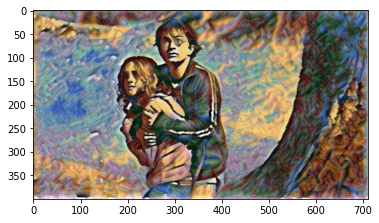

 92%|█████████▏| 5509/6000 [05:30<00:44, 11.01it/s]

epoch  5510   

 92%|█████████▏| 5516/6000 [05:30<00:35, 13.47it/s]

tensor(7.4245e+17, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 5519/6000 [05:31<00:33, 14.34it/s]

epoch  5520   

 92%|█████████▏| 5526/6000 [05:31<00:30, 15.65it/s]

tensor(7.4200e+17, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 5529/6000 [05:31<00:29, 16.01it/s]

epoch  5530   

 92%|█████████▏| 5536/6000 [05:32<00:28, 16.57it/s]

tensor(7.4205e+17, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 5539/6000 [05:32<00:27, 16.67it/s]

epoch  5540   

 92%|█████████▏| 5546/6000 [05:32<00:26, 16.92it/s]

tensor(7.4218e+17, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 5549/6000 [05:32<00:26, 16.91it/s]

epoch  5550   

 93%|█████████▎| 5556/6000 [05:33<00:26, 17.04it/s]

tensor(7.4182e+17, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 5559/6000 [05:33<00:25, 17.00it/s]

epoch  5560   

 93%|█████████▎| 5566/6000 [05:33<00:28, 15.03it/s]

tensor(7.4198e+17, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 5569/6000 [05:34<00:27, 15.55it/s]

epoch  5570   

 93%|█████████▎| 5576/6000 [05:34<00:25, 16.33it/s]

tensor(7.4153e+17, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 5579/6000 [05:34<00:25, 16.50it/s]

epoch  5580   

 93%|█████████▎| 5586/6000 [05:35<00:24, 16.83it/s]

tensor(7.4193e+17, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 5589/6000 [05:35<00:24, 16.85it/s]

epoch  5590   

 93%|█████████▎| 5596/6000 [05:35<00:23, 17.01it/s]

tensor(7.4149e+17, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 5599/6000 [05:35<00:23, 16.98it/s]

epoch  5600   

 93%|█████████▎| 5606/6000 [05:36<00:23, 17.06it/s]

tensor(7.4151e+17, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 5609/6000 [05:36<00:22, 17.02it/s]

epoch  5610   

 94%|█████████▎| 5616/6000 [05:36<00:22, 17.09it/s]

tensor(7.4154e+17, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▎| 5619/6000 [05:36<00:22, 17.03it/s]

epoch  5620   

 94%|█████████▍| 5626/6000 [05:37<00:24, 15.08it/s]

tensor(7.4125e+17, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 5629/6000 [05:37<00:23, 15.58it/s]

epoch  5630   

 94%|█████████▍| 5636/6000 [05:37<00:22, 16.35it/s]

tensor(7.4150e+17, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 5639/6000 [05:38<00:21, 16.51it/s]

epoch  5640   

 94%|█████████▍| 5646/6000 [05:38<00:21, 16.83it/s]

tensor(7.4125e+17, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 5649/6000 [05:38<00:20, 16.85it/s]

epoch  5650   

 94%|█████████▍| 5656/6000 [05:39<00:20, 17.01it/s]

tensor(7.4146e+17, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 5659/6000 [05:39<00:20, 16.98it/s]

epoch  5660   

 94%|█████████▍| 5666/6000 [05:39<00:22, 15.04it/s]

tensor(7.4158e+17, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 5669/6000 [05:39<00:21, 15.56it/s]

epoch  5670   

 95%|█████████▍| 5676/6000 [05:40<00:19, 16.33it/s]

tensor(7.4135e+17, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▍| 5679/6000 [05:40<00:19, 16.50it/s]

epoch  5680   

 95%|█████████▍| 5686/6000 [05:40<00:18, 16.83it/s]

tensor(7.4174e+17, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▍| 5689/6000 [05:41<00:18, 16.85it/s]

epoch  5690   

 95%|█████████▍| 5696/6000 [05:41<00:17, 17.00it/s]

tensor(7.4141e+17, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▍| 5699/6000 [05:41<00:17, 16.97it/s]

epoch  5700   

 95%|█████████▌| 5706/6000 [05:42<00:19, 15.06it/s]

tensor(7.4148e+17, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 5709/6000 [05:42<00:18, 15.57it/s]

epoch  5710   

 95%|█████████▌| 5716/6000 [05:42<00:17, 16.34it/s]

tensor(7.4170e+17, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 5719/6000 [05:42<00:17, 16.50it/s]

epoch  5720   

 95%|█████████▌| 5726/6000 [05:43<00:16, 16.83it/s]

tensor(7.4117e+17, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 5729/6000 [05:43<00:16, 16.85it/s]

epoch  5730   

 96%|█████████▌| 5736/6000 [05:43<00:15, 17.00it/s]

tensor(7.4133e+17, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 5739/6000 [05:44<00:15, 16.97it/s]

epoch  5740   

 96%|█████████▌| 5746/6000 [05:44<00:16, 15.05it/s]

tensor(7.4087e+17, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 5749/6000 [05:44<00:16, 15.56it/s]

epoch  5750   

 96%|█████████▌| 5756/6000 [05:45<00:14, 16.34it/s]

tensor(7.4102e+17, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 5759/6000 [05:45<00:14, 16.50it/s]

epoch  5760   

 96%|█████████▌| 5766/6000 [05:45<00:13, 16.83it/s]

tensor(7.4089e+17, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 5769/6000 [05:45<00:13, 16.85it/s]

epoch  5770   

 96%|█████████▋| 5776/6000 [05:46<00:13, 17.01it/s]

tensor(7.4151e+17, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▋| 5779/6000 [05:46<00:13, 16.98it/s]

epoch  5780   

 96%|█████████▋| 5786/6000 [05:46<00:14, 15.05it/s]

tensor(7.4095e+17, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▋| 5789/6000 [05:47<00:13, 15.56it/s]

epoch  5790   

 97%|█████████▋| 5796/6000 [05:47<00:12, 16.34it/s]

tensor(7.4078e+17, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 5799/6000 [05:47<00:12, 16.50it/s]

epoch  5800   

 97%|█████████▋| 5806/6000 [05:48<00:11, 16.83it/s]

tensor(7.4085e+17, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 5809/6000 [05:48<00:11, 16.85it/s]

epoch  5810   

 97%|█████████▋| 5816/6000 [05:48<00:10, 17.01it/s]

tensor(7.4062e+17, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 5819/6000 [05:48<00:10, 16.98it/s]

epoch  5820   

 97%|█████████▋| 5826/6000 [05:49<00:10, 17.07it/s]

tensor(7.4079e+17, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 5829/6000 [05:49<00:10, 17.02it/s]

epoch  5830   

 97%|█████████▋| 5836/6000 [05:49<00:10, 15.07it/s]

tensor(7.4055e+17, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 5839/6000 [05:50<00:10, 15.57it/s]

epoch  5840   

 97%|█████████▋| 5846/6000 [05:50<00:09, 16.34it/s]

tensor(7.4092e+17, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 5849/6000 [05:50<00:09, 16.51it/s]

epoch  5850   

 98%|█████████▊| 5856/6000 [05:51<00:08, 16.83it/s]

tensor(7.4032e+17, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 5859/6000 [05:51<00:08, 16.85it/s]

epoch  5860   

 98%|█████████▊| 5866/6000 [05:51<00:07, 17.01it/s]

tensor(7.4055e+17, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 5869/6000 [05:51<00:07, 16.98it/s]

epoch  5870   

 98%|█████████▊| 5876/6000 [05:52<00:08, 15.05it/s]

tensor(7.3997e+17, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 5879/6000 [05:52<00:07, 15.57it/s]

epoch  5880   

 98%|█████████▊| 5886/6000 [05:52<00:06, 16.31it/s]

tensor(7.4027e+17, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 5889/6000 [05:52<00:06, 16.48it/s]

epoch  5890   

 98%|█████████▊| 5896/6000 [05:53<00:06, 16.82it/s]

tensor(7.3976e+17, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 5899/6000 [05:53<00:05, 16.85it/s]

epoch  5900   

 98%|█████████▊| 5906/6000 [05:53<00:05, 17.00it/s]

tensor(7.4006e+17, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 5909/6000 [05:54<00:05, 16.97it/s]

epoch  5910   

 99%|█████████▊| 5916/6000 [05:54<00:05, 15.04it/s]

tensor(7.3965e+17, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▊| 5919/6000 [05:54<00:05, 15.56it/s]

epoch  5920   

 99%|█████████▉| 5926/6000 [05:55<00:04, 16.33it/s]

tensor(7.4004e+17, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▉| 5929/6000 [05:55<00:04, 16.50it/s]

epoch  5930   

 99%|█████████▉| 5936/6000 [05:55<00:03, 16.83it/s]

tensor(7.3986e+17, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▉| 5939/6000 [05:55<00:03, 16.85it/s]

epoch  5940   

 99%|█████████▉| 5946/6000 [05:56<00:03, 17.00it/s]

tensor(7.3957e+17, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▉| 5949/6000 [05:56<00:03, 16.97it/s]

epoch  5950   

 99%|█████████▉| 5956/6000 [05:56<00:02, 15.04it/s]

tensor(7.3974e+17, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▉| 5959/6000 [05:57<00:02, 15.56it/s]

epoch  5960   

 99%|█████████▉| 5966/6000 [05:57<00:02, 16.33it/s]

tensor(7.3934e+17, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▉| 5969/6000 [05:57<00:01, 16.50it/s]

epoch  5970   

100%|█████████▉| 5976/6000 [05:58<00:01, 16.83it/s]

tensor(7.3974e+17, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████▉| 5979/6000 [05:58<00:01, 16.85it/s]

epoch  5980   

100%|█████████▉| 5986/6000 [05:58<00:00, 16.99it/s]

tensor(7.3946e+17, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████▉| 5989/6000 [05:58<00:00, 16.97it/s]

epoch  5990   

100%|█████████▉| 5996/6000 [05:59<00:00, 17.01it/s]

tensor(7.3927e+17, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████▉| 5999/6000 [05:59<00:00, 16.98it/s]

epoch  6000   tensor(7.3948e+17, device='cuda:0', grad_fn=<AddBackward0>)


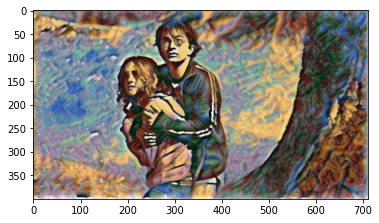

100%|██████████| 6000/6000 [06:00<00:00, 16.66it/s]


In [14]:
for i in tqdm(range(1,epochs+1)):
    target_features = model_activation_apply(target,model)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_wt_meas:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _,d,w,h = target_gram.shape
        target_gram = gram_matrix(target_gram)

        style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h
    
    total_loss = content_wt*content_loss + style_wt*style_loss 
    
    # Print losses
    if i % 10 == 0:       
        print("epoch ", i," ", total_loss)
      
    # loop
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # print after some iterations (500)
    if i % prt == 0:
        plt.imshow(img_convert(target),label="Epoch "+str(i))
        plt.show()
        # insert path accordingly
        plt.imsave('/content/drive/My Drive/Neural_Style/' + str(i)+'.png',img_convert(target),format='png')
